In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np

In [39]:
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor


In [ ]:
!pip install xgboost

## Train, Validation, Test

In [3]:
weather_cleaned = pd.read_csv("final_cleaned_data/weather_yield_x_normalize.csv").drop(columns=["Unnamed: 0"], axis=1)

In [4]:
training = weather_cleaned.copy()

In [5]:
def columns_with_mostly_zeros(df, threshold=0.95):
    """
    Get columns where 95% or more of the values are zero.

    Parameters:
    - df: DataFrame
        The input DataFrame.
    - threshold: float, optional (default=0.95)
        The threshold percentage for determining if a column contains mostly zeros.

    Returns:
    - list
        A list of column names where 95% or more of the values are zero.
    """
    # Calculate the percentage of zeros in each column
    zero_counts = (df == 0).mean()

    # Filter columns where the percentage of zeros exceeds the threshold
    mostly_zeros_columns = zero_counts[zero_counts >= threshold].index.tolist()

    return mostly_zeros_columns

In [6]:
# Assuming df is your DataFrame
mostly_zeros_columns = columns_with_mostly_zeros(training)
print("Columns with 95% or more zeros:", mostly_zeros_columns)

Columns with 95% or more zeros: ['DT00_4', 'DT00_5', 'DT00_6', 'DT00_7', 'DT00_8', 'DT00_9', 'DT00_10', 'DT32_6', 'DT32_7', 'DT32_8', 'DT32_9', 'DX32_4', 'DX32_5', 'DX32_6', 'DX32_7', 'DX32_8', 'DX32_9', 'DX32_10', 'DX90_4', 'EMSD_5', 'EMSD_6', 'EMSD_7', 'EMSD_8', 'EMSD_9', 'EMSD_10', 'SNOW_5', 'SNOW_6', 'SNOW_7', 'SNOW_8', 'SNOW_9', 'SNOW_10']


In [7]:
#training_v2 = training.drop(columns=columns_with_one_unique_value, axis=1)

training_v2 = training.drop(columns=mostly_zeros_columns, axis=1)

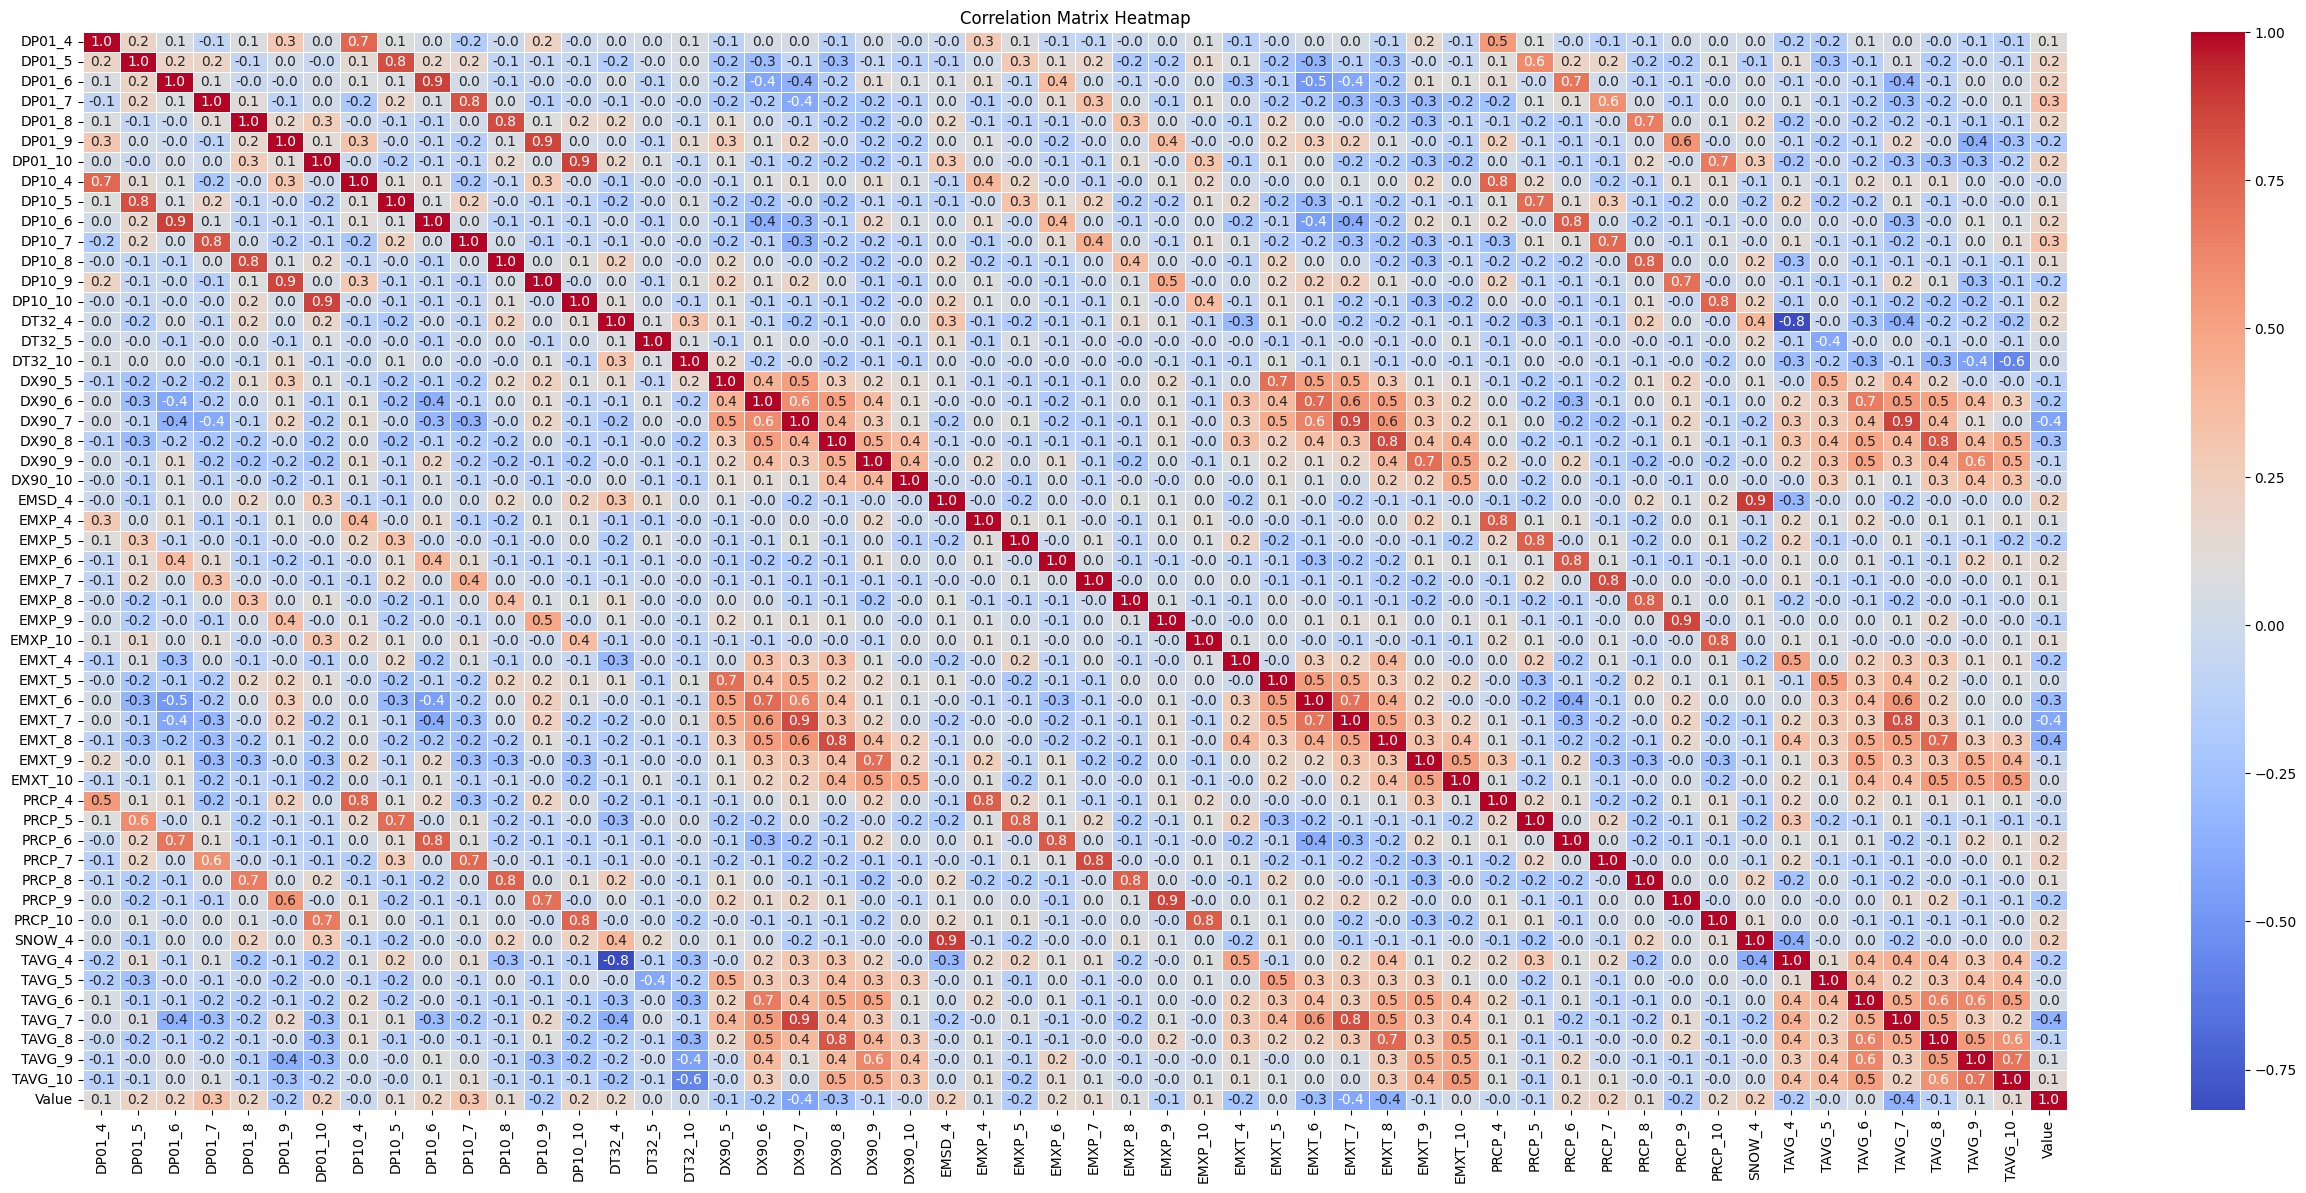

In [8]:
correlation = training_v2.drop(columns=["County", "Year"], axis=1)

# Calculate the correlation matrix
correlation_matrix = correlation.corr()

# Create a heatmap
plt.figure(figsize=(32, 14))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.1f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [9]:
training_years = [2002, 2003, 2004, 2005, 2006, 2007,  2009, 2010, 2011, 2012, 2013, 2015, 2016, 2017, 2018, 2019,  2021, 2022]
hold_out_years = [2008,2014, 2020]


train_rows_bool = training_v2['Year'].isin(training_years)
hold_rows_bool = training_v2['Year'].isin(hold_out_years)

train_rows = training_v2[train_rows_bool]
hold_rows = training_v2[hold_rows_bool]


In [10]:
print(train_rows.shape)
print(hold_rows.shape)

(1424, 56)
(253, 56)


## Split into training, validation and test

In [11]:
X = train_rows.drop(columns=["County", "Year", "Value"], axis=1)
y = train_rows["Value"]

X_hold= hold_rows.drop(columns=["County", "Year", "Value"], axis=1)
y_hold = hold_rows["Value"]

In [12]:
# [2002, 2003, 2004, 2005, 2006, 2007,  2009, 2010, 2011, 2012, 2013, 2015, 2016, 2017, 2018, 2019,  2021, 2022]

print(X.shape) 
print(y.shape)


# [2008,2014, 2020]
print(X_hold.shape)
print(y_hold.shape)

(1424, 53)
(1424,)
(253, 53)
(253,)


## train_test_split for Training and Validation

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

## Normalization

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

In [15]:
columns_mode = [
'DP01_4', 'DP01_5', 'DP01_6', 'DP01_7', 'DP01_8', 
                'DP01_9', 'DP01_10', 'DP10_4', 'DP10_5', 
                'DP10_6', 'DP10_7', 'DP10_8', 'DP10_9', 'DP10_10',
'DT32_4', 'DT32_5', 
 'DT32_10',   'DX90_5', 'DX90_6', 'DX90_7', 'DX90_8', 
                            'DX90_9', 'DX90_10',  'EMXP_4', 'EMXP_5', 'EMXP_6', 'EMXP_7', 'EMXP_8', 
                            
                            'EMSD_4',   
                            
                            'EMXP_9', 'EMXP_10', 'PRCP_4', 'PRCP_5', 'PRCP_6', 'PRCP_7', 'PRCP_8', 
                'PRCP_9', 'PRCP_10', 'SNOW_4',  ]


columns_mean = [
                'EMXT_4', 'EMXT_5', 'EMXT_6', 'EMXT_7', 'EMXT_8', 
                'EMXT_9', 'EMXT_10',  'TAVG_4', 'TAVG_5', 'TAVG_6', 'TAVG_7', 'TAVG_8', 
                'TAVG_9', 'TAVG_10' ]

In [16]:
# Extract the columns based on the shape

X_skewed_train = X_train[columns_mode]
X_normal_train = X_train[columns_mean]

X_skewed_test = X_test[columns_mode]
X_normal_test = X_test[columns_mean]

X_skewed_hold = X_hold[columns_mode]
X_normal_hold = X_hold[columns_mean]

In [17]:
# scaler

scaler = StandardScaler()
scaler.fit(X_normal_train)

StandardScaler()

In [18]:

X_normal_train_scaled = pd.DataFrame(scaler.transform(X_normal_train), columns=columns_mean)
X_normal_test_scaled = pd.DataFrame(scaler.transform(X_normal_test), columns=columns_mean)
X_normal_hold_scaled = pd.DataFrame(scaler.transform(X_normal_hold), columns=columns_mean)

In [19]:
r_scaler = RobustScaler()
r_scaler.fit(X_skewed_train)

RobustScaler()

In [21]:
X_skewed_train_scaled = pd.DataFrame(r_scaler.transform(X_skewed_train), columns=columns_mode)
X_skewed_test_scaled = pd.DataFrame(r_scaler.transform(X_skewed_test), columns=columns_mode)
X_skewed_hold_scaled = pd.DataFrame(r_scaler.transform(X_skewed_hold), columns=columns_mode)

In [23]:
# Combine them


X_train_scaled = pd.concat([X_normal_train_scaled , X_skewed_train_scaled], axis=1)
X_test_scaled= pd.concat([X_normal_test_scaled , X_skewed_test_scaled], axis=1)
X_hold_scaled= pd.concat([X_normal_hold_scaled, X_skewed_hold_scaled], axis=1)


## Box and Whiskers Plot (Visualize Outliers)

In [24]:

# The first 22 columns of the training 
X_train_scaled_subset_1 = X_train_scaled.iloc[:, :22]

# The last 21 columns of the training
X_train_scaled_subset_2 = X_train_scaled.iloc[:, -21:]

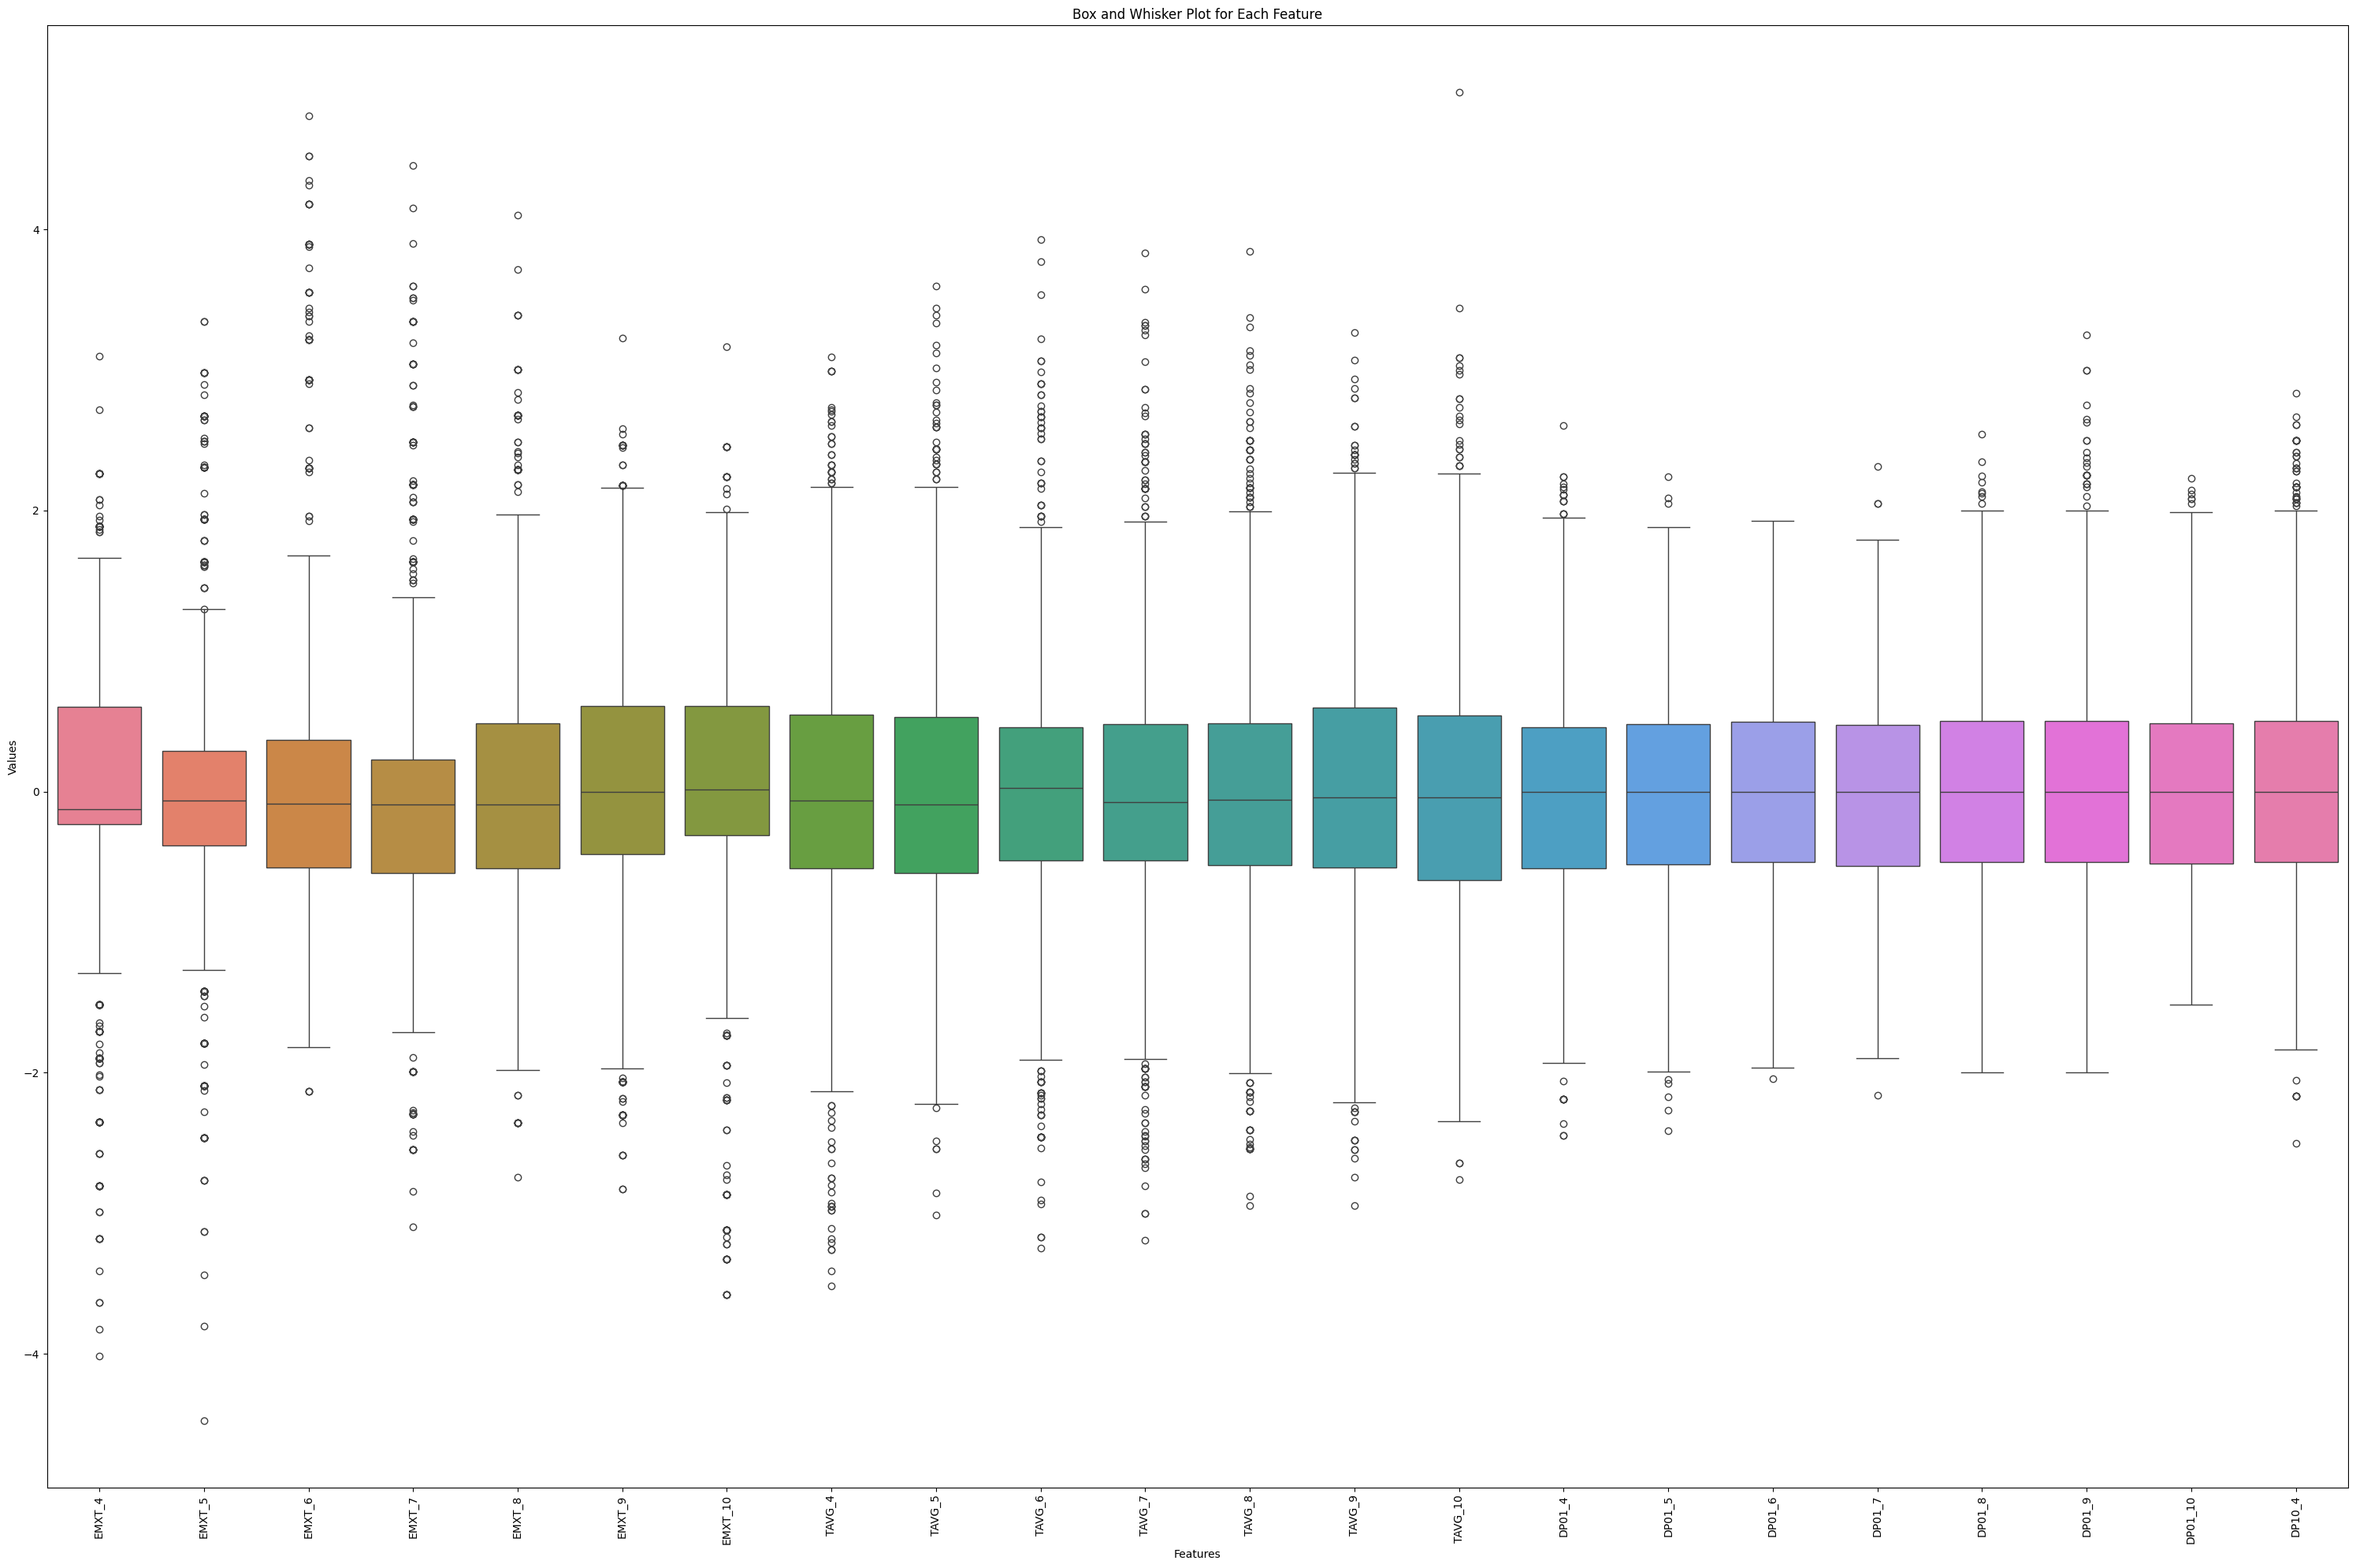

In [25]:
# Assuming df is your DataFrame containing your dataset
# Create a box and whisker plot for each feature
plt.figure(figsize=(30, 20))
sns.boxplot(data=X_train_scaled_subset_1)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.xlabel('Features')
plt.ylabel('Values')
plt.title('Box and Whisker Plot for Each Feature')
plt.tight_layout()
plt.show()

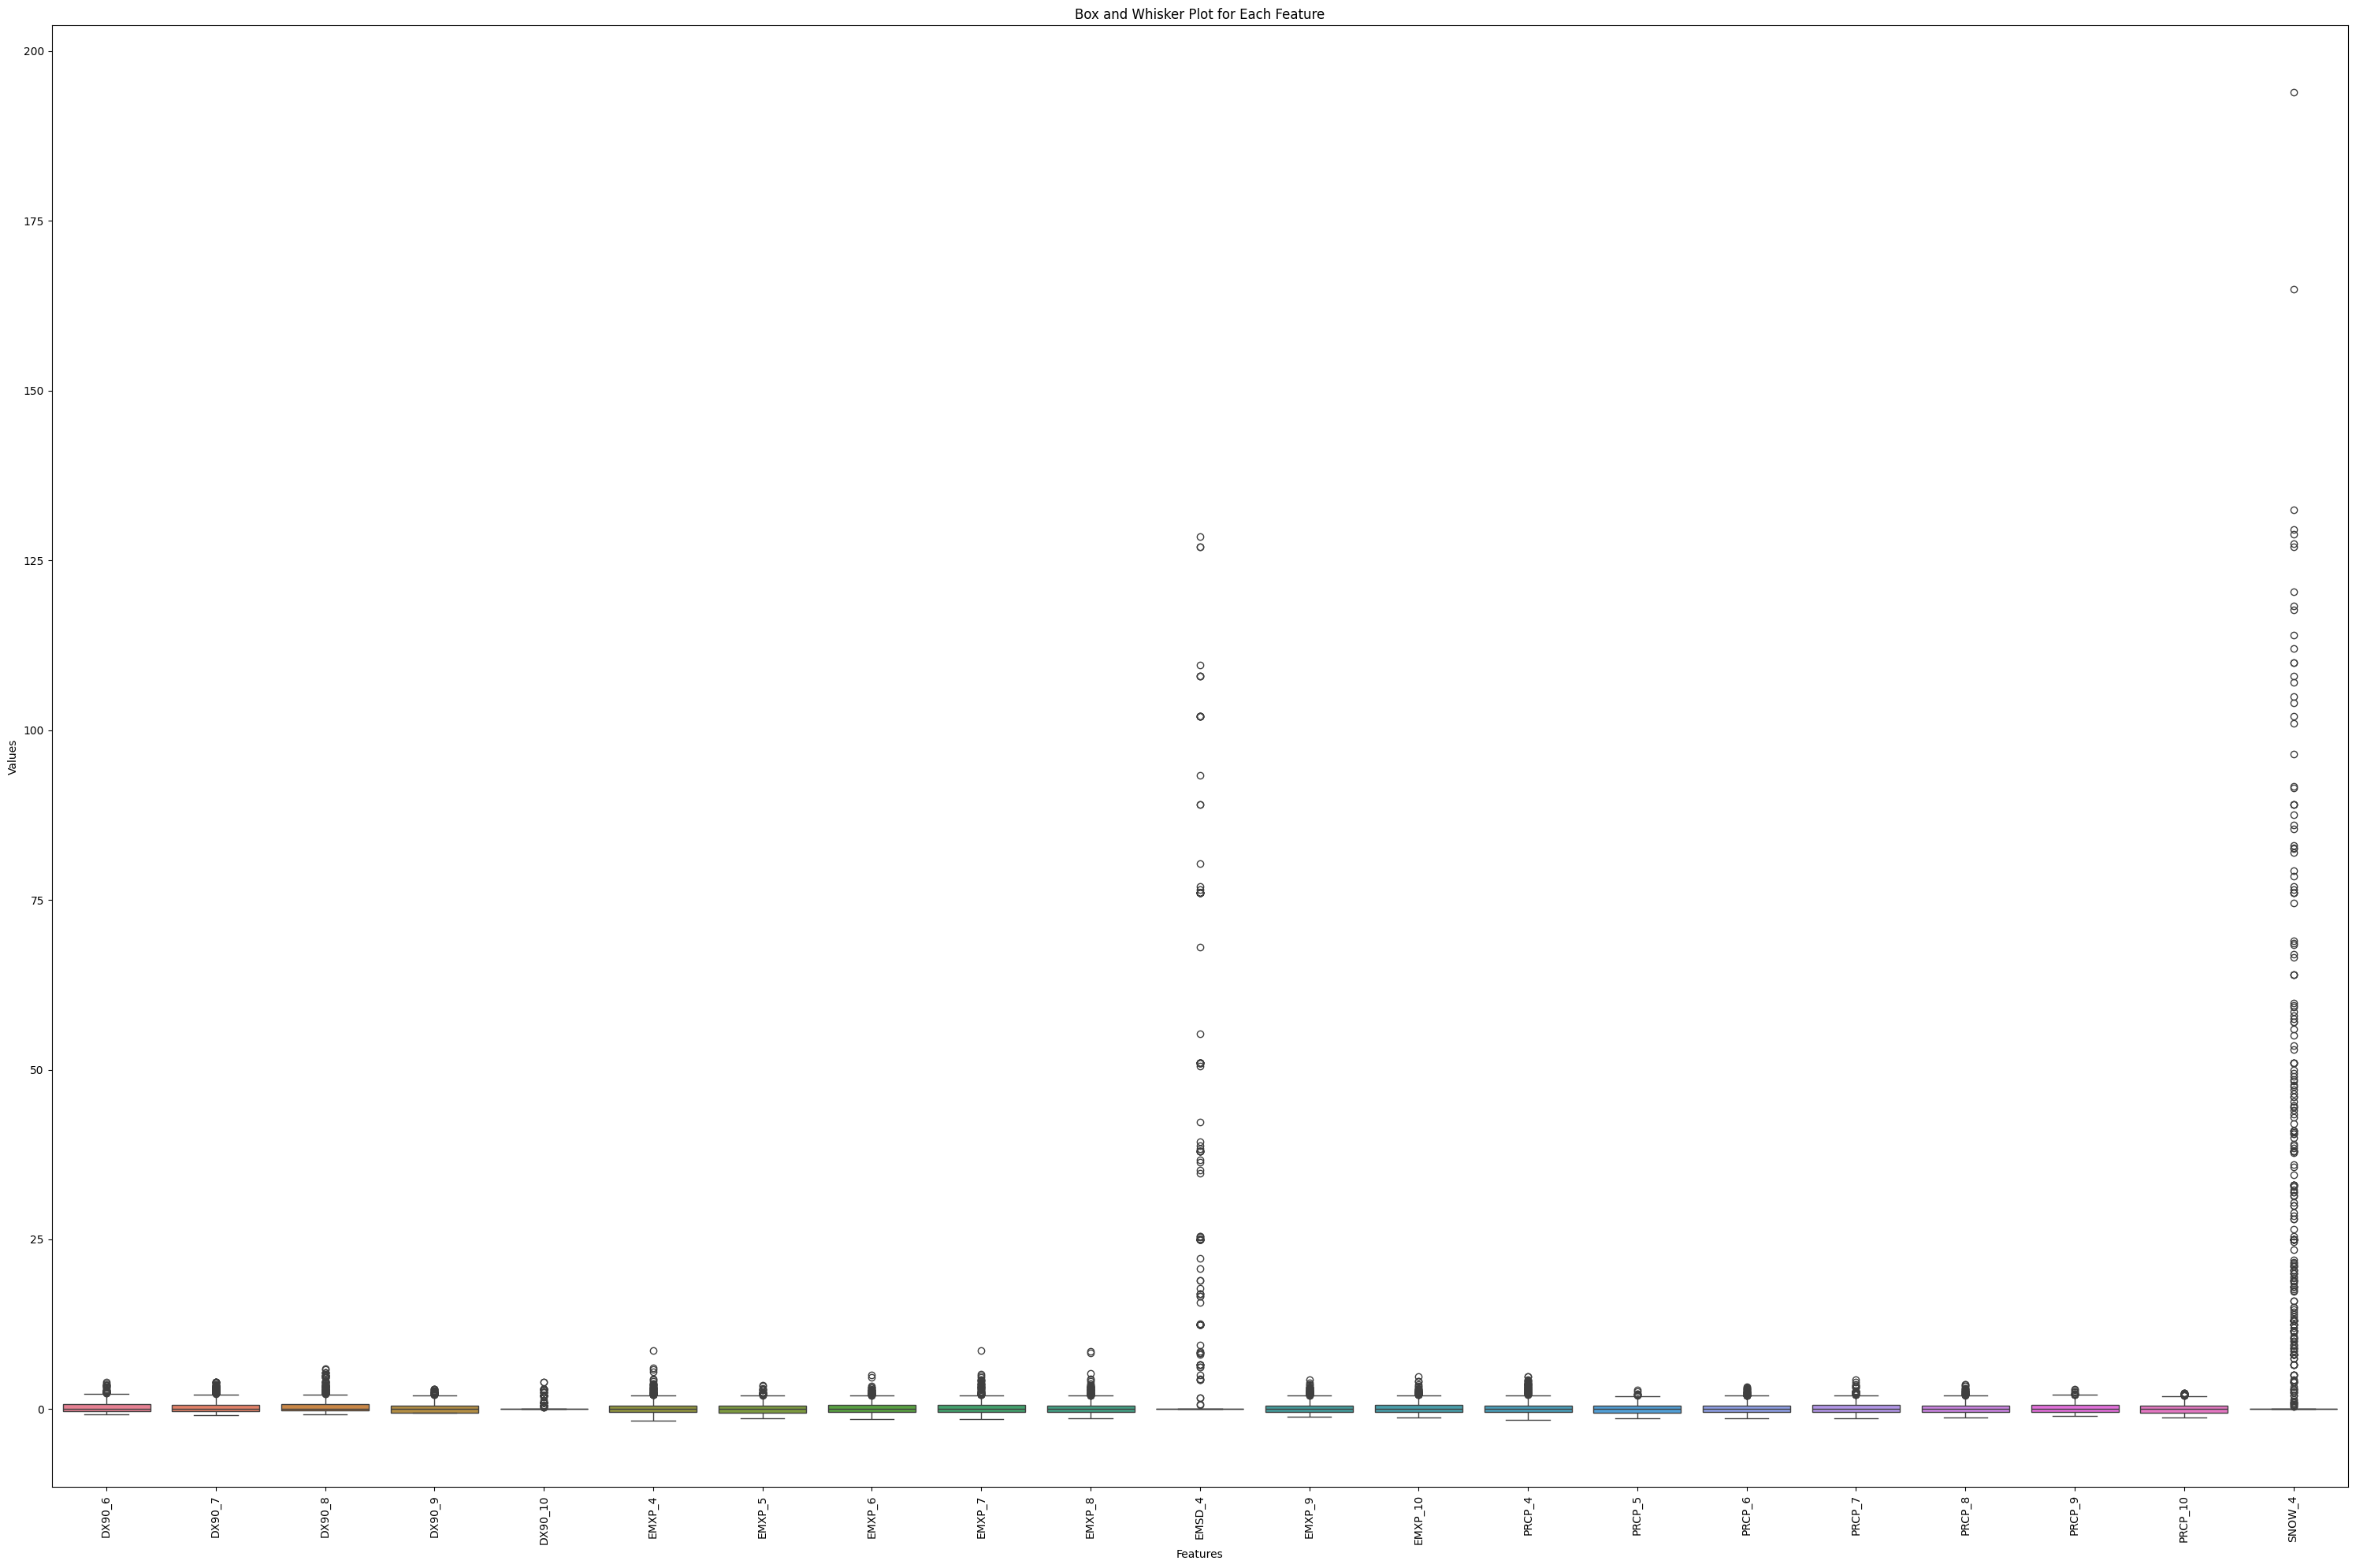

In [26]:
# Assuming df is your DataFrame containing your dataset
# Create a box and whisker plot for each feature
plt.figure(figsize=(30, 20))
sns.boxplot(data=X_train_scaled_subset_2)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.xlabel('Features')
plt.ylabel('Values')
plt.title('Box and Whisker Plot for Each Feature')
plt.tight_layout()
plt.show()

Too many outliers in some features

In [29]:
# Visualization for testing

X_hold_scaled_subset_1= X_hold_scaled.iloc[:, :22]
X_hold_scaled_subset_2 = X_hold_scaled.iloc[:, -21:]


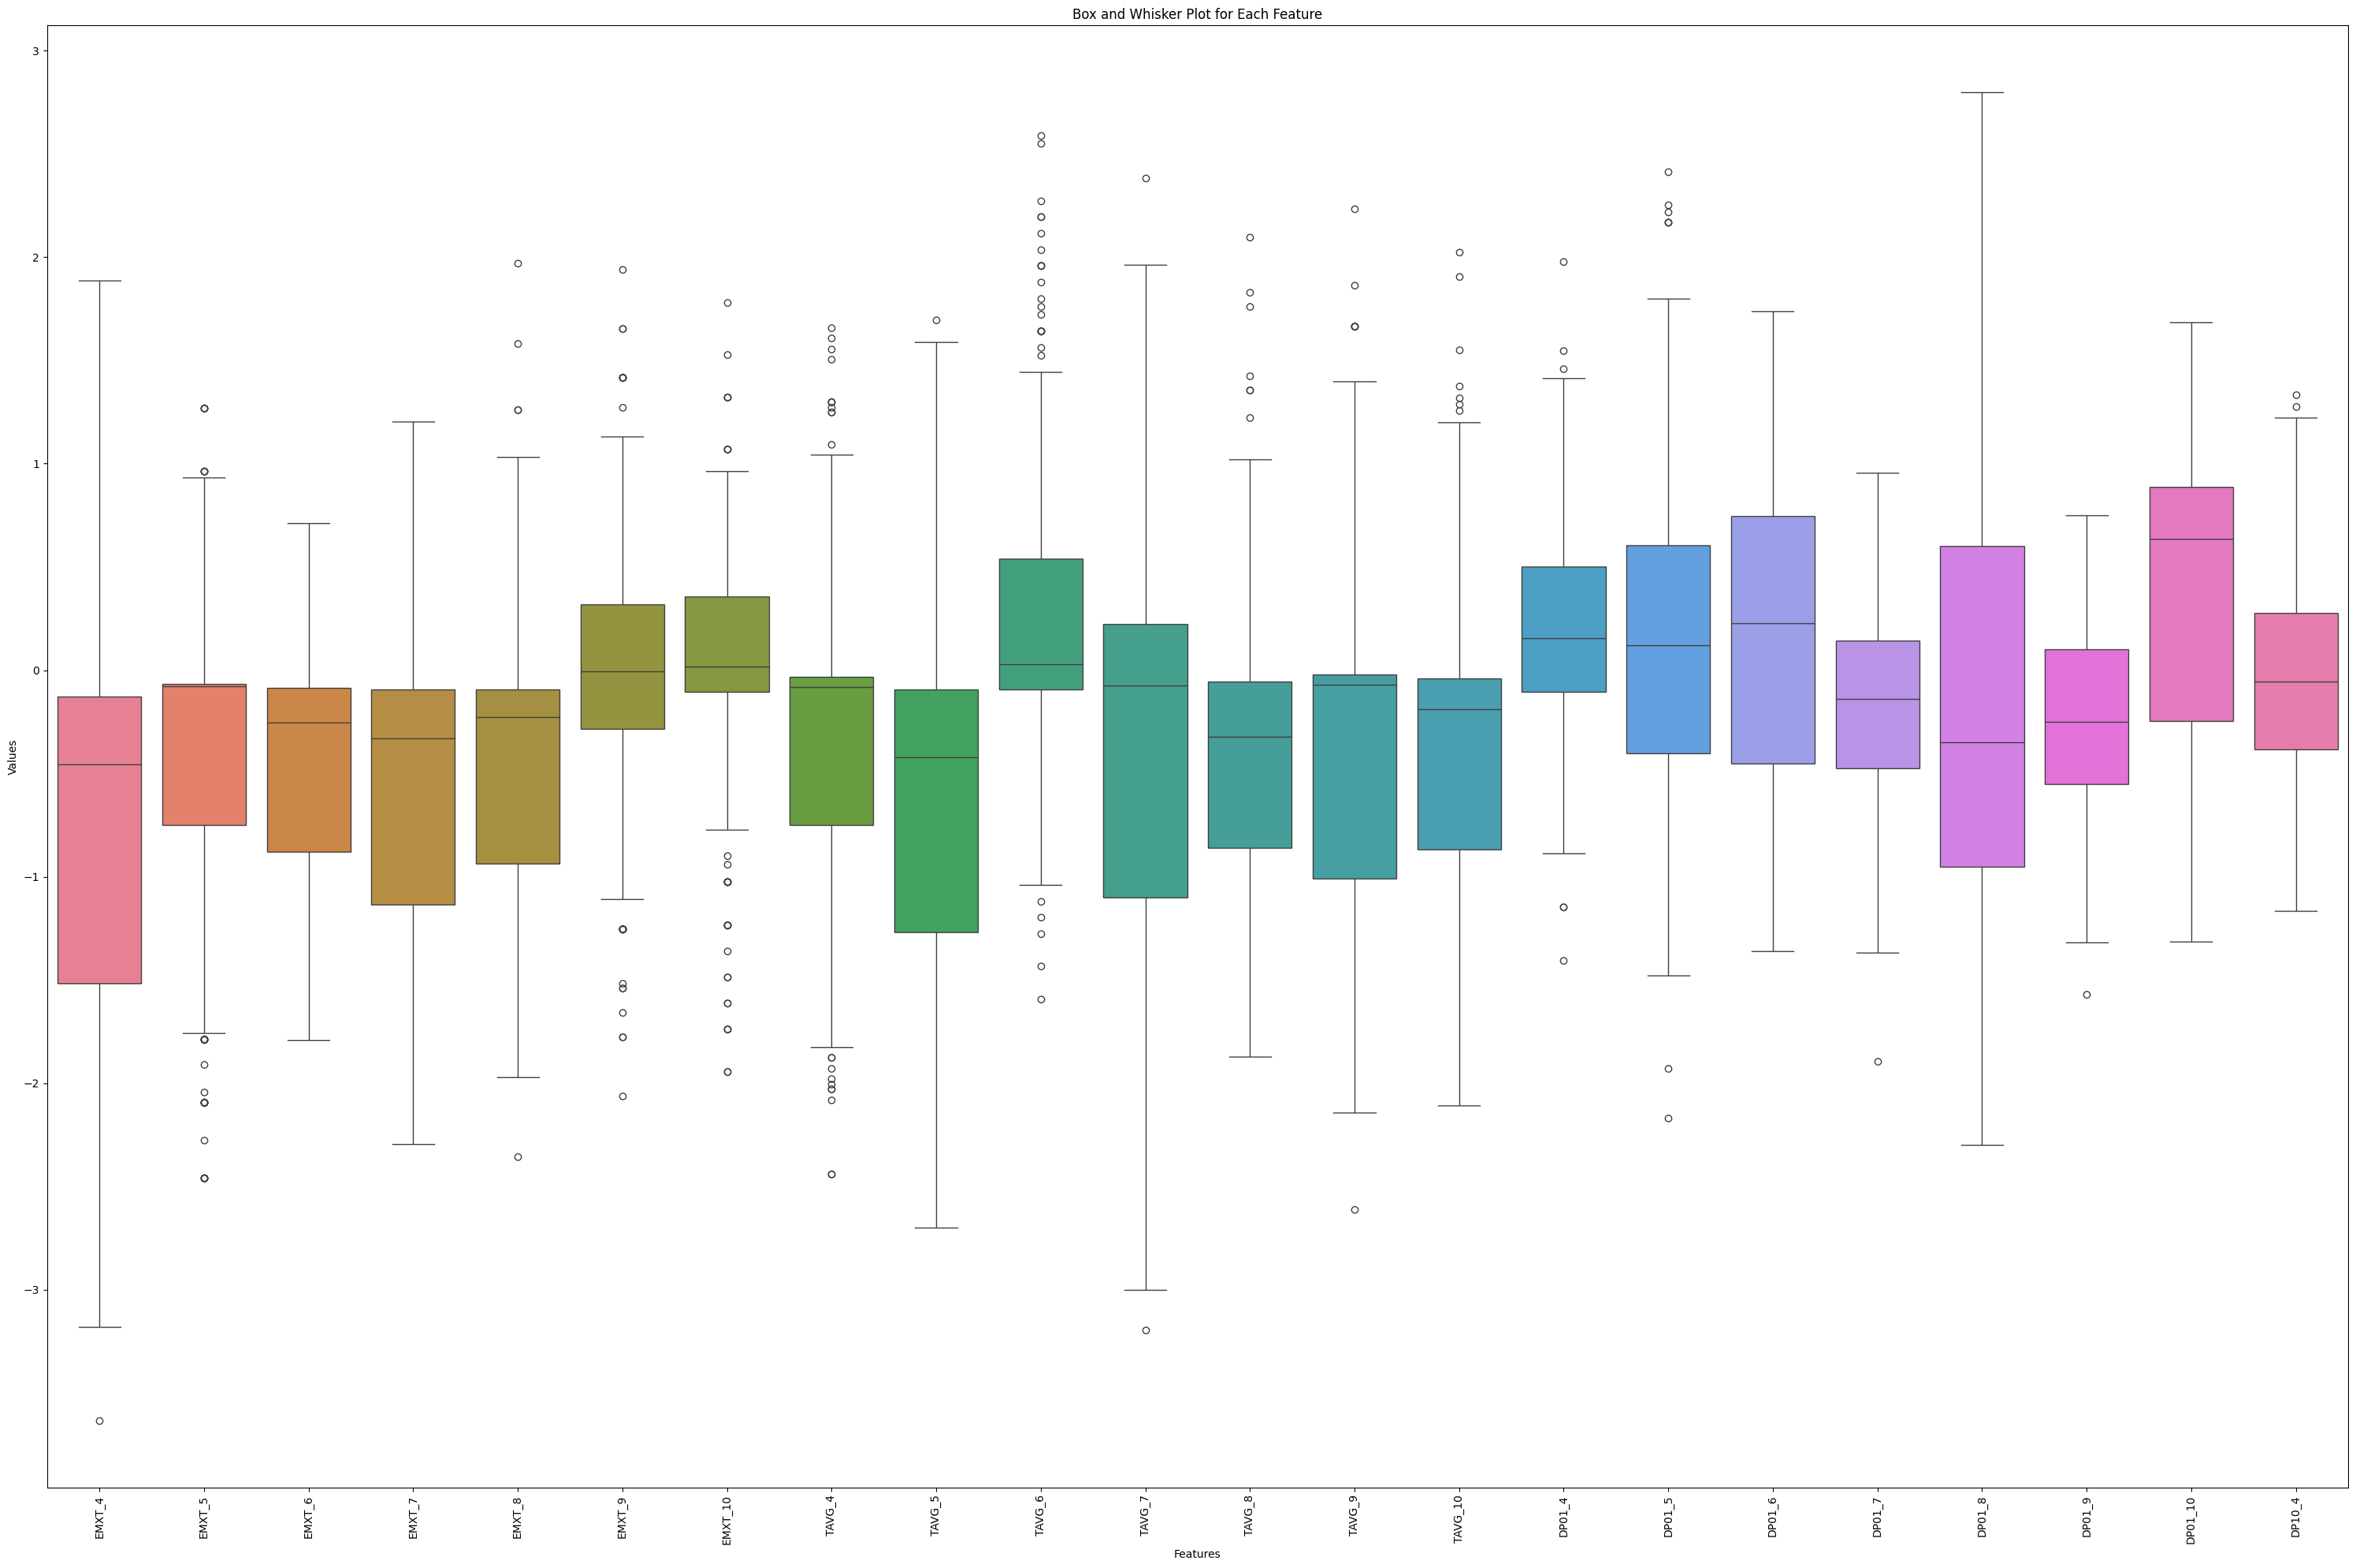

In [30]:
# Assuming df is your DataFrame containing your dataset
# Create a box and whisker plot for each feature
plt.figure(figsize=(30, 20))
sns.boxplot(data=X_hold_scaled_subset_1)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.xlabel('Features')
plt.ylabel('Values')
plt.title('Box and Whisker Plot for Each Feature')
plt.tight_layout()
plt.show()

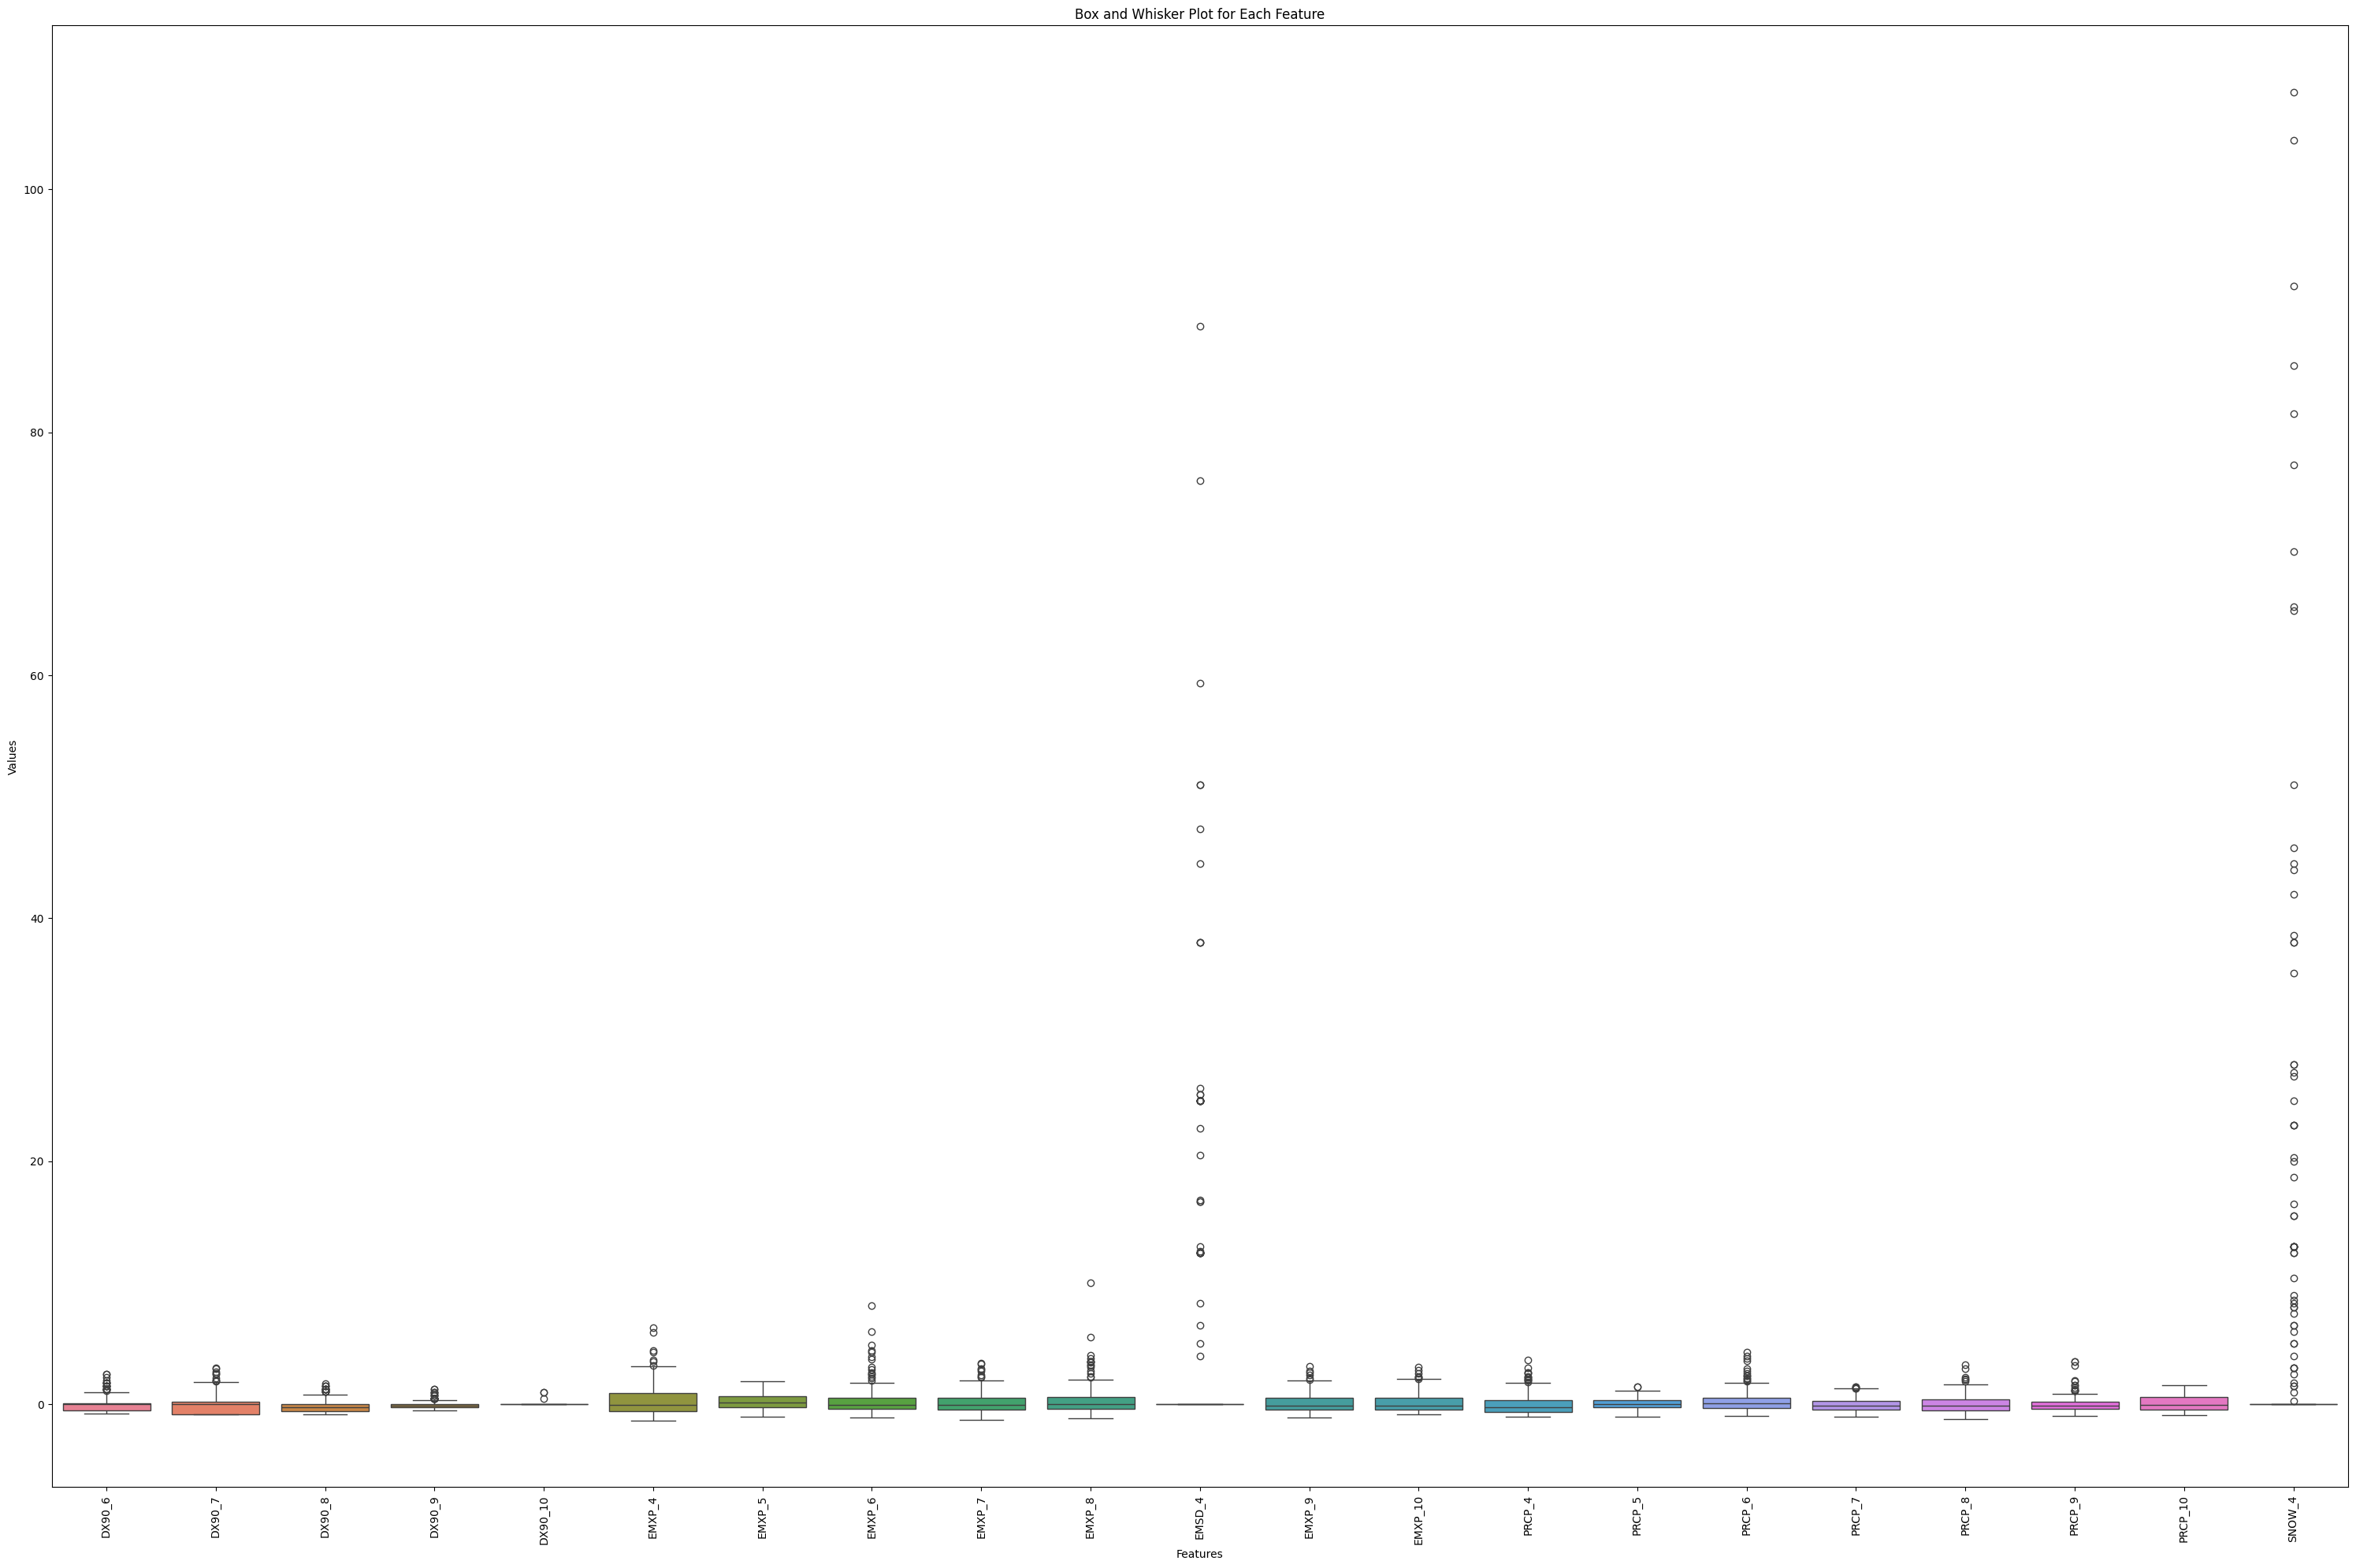

In [31]:
# Assuming df is your DataFrame containing your dataset
# Create a box and whisker plot for each feature
plt.figure(figsize=(30, 20))
sns.boxplot(data=X_hold_scaled_subset_2)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.xlabel('Features')
plt.ylabel('Values')
plt.title('Box and Whisker Plot for Each Feature')
plt.tight_layout()
plt.show()

Similar pattern with Training set

In [32]:
X_train_scaled_subset_3 = X_train_scaled_subset_2.drop(columns=["EMSD_4", "SNOW_4"],axis=1)
X_hold_scaled_subset_3 = X_hold_scaled_subset_2.drop(columns=["EMSD_4", "SNOW_4"],axis=1)

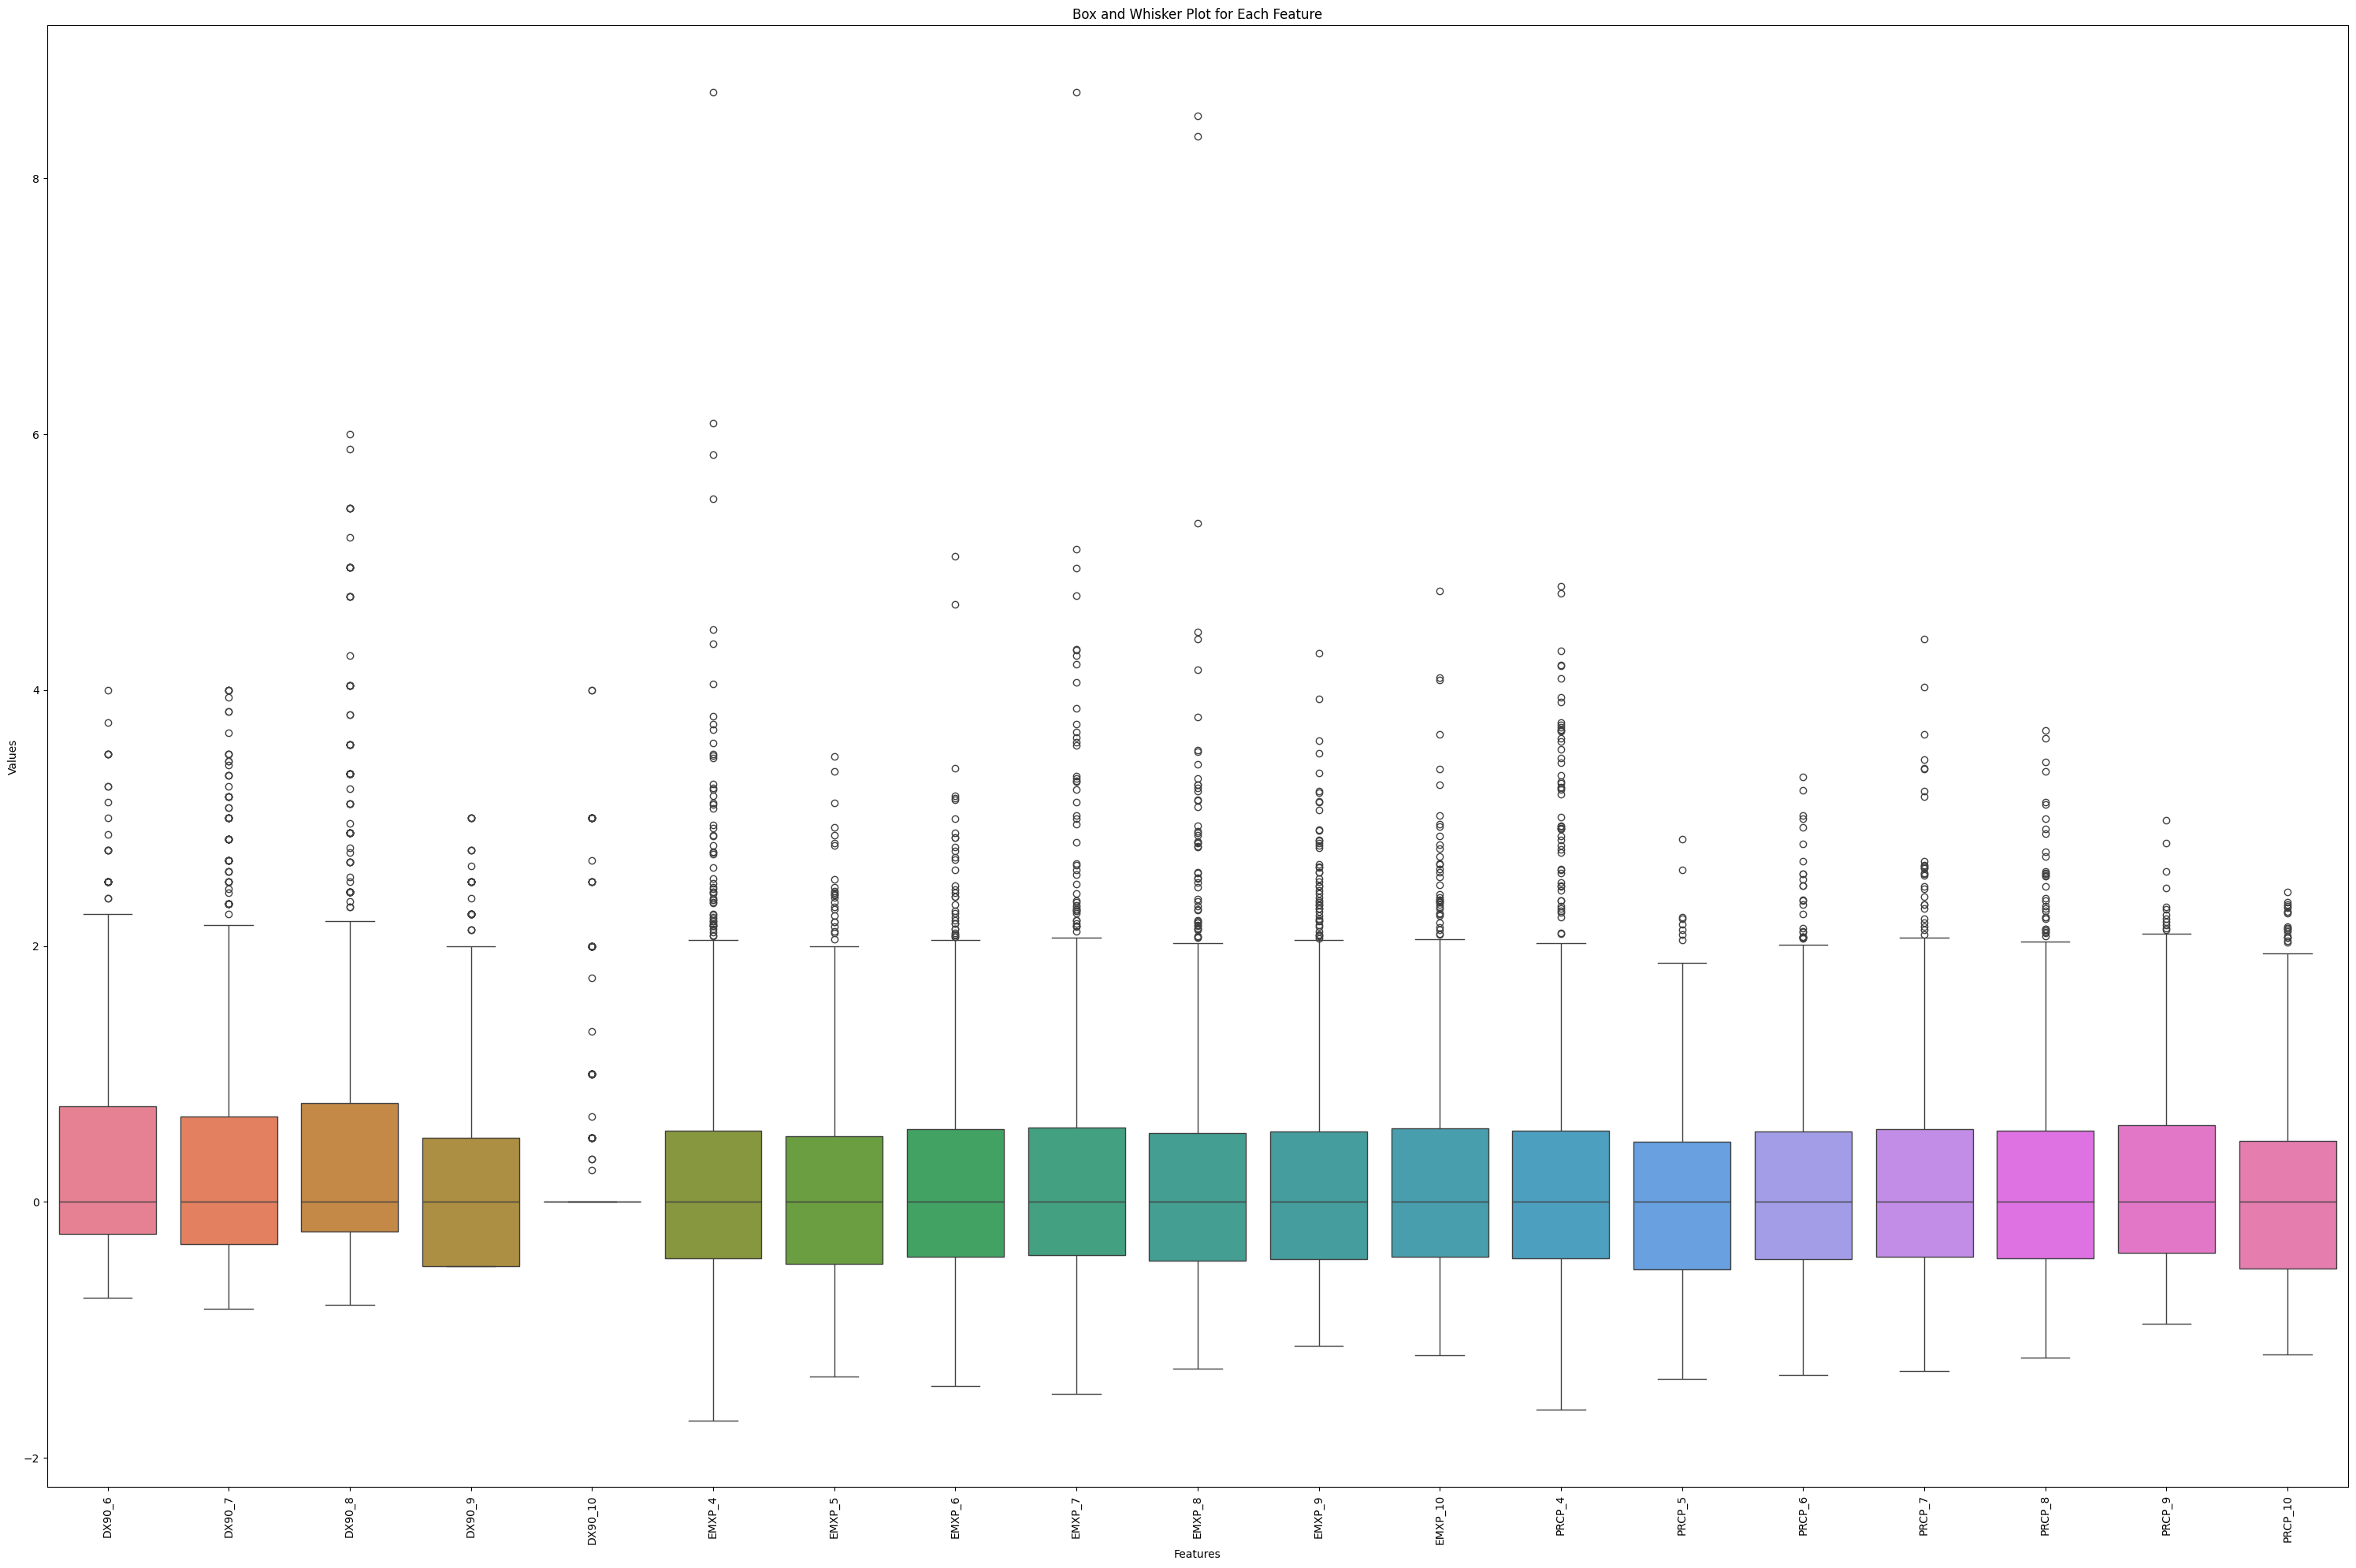

In [33]:
# Assuming df is your DataFrame containing your dataset
# Create a box and whisker plot for each feature
plt.figure(figsize=(30, 20))
sns.boxplot(data=X_train_scaled_subset_3)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.xlabel('Features')
plt.ylabel('Values')
plt.title('Box and Whisker Plot for Each Feature')
plt.tight_layout()
plt.show()

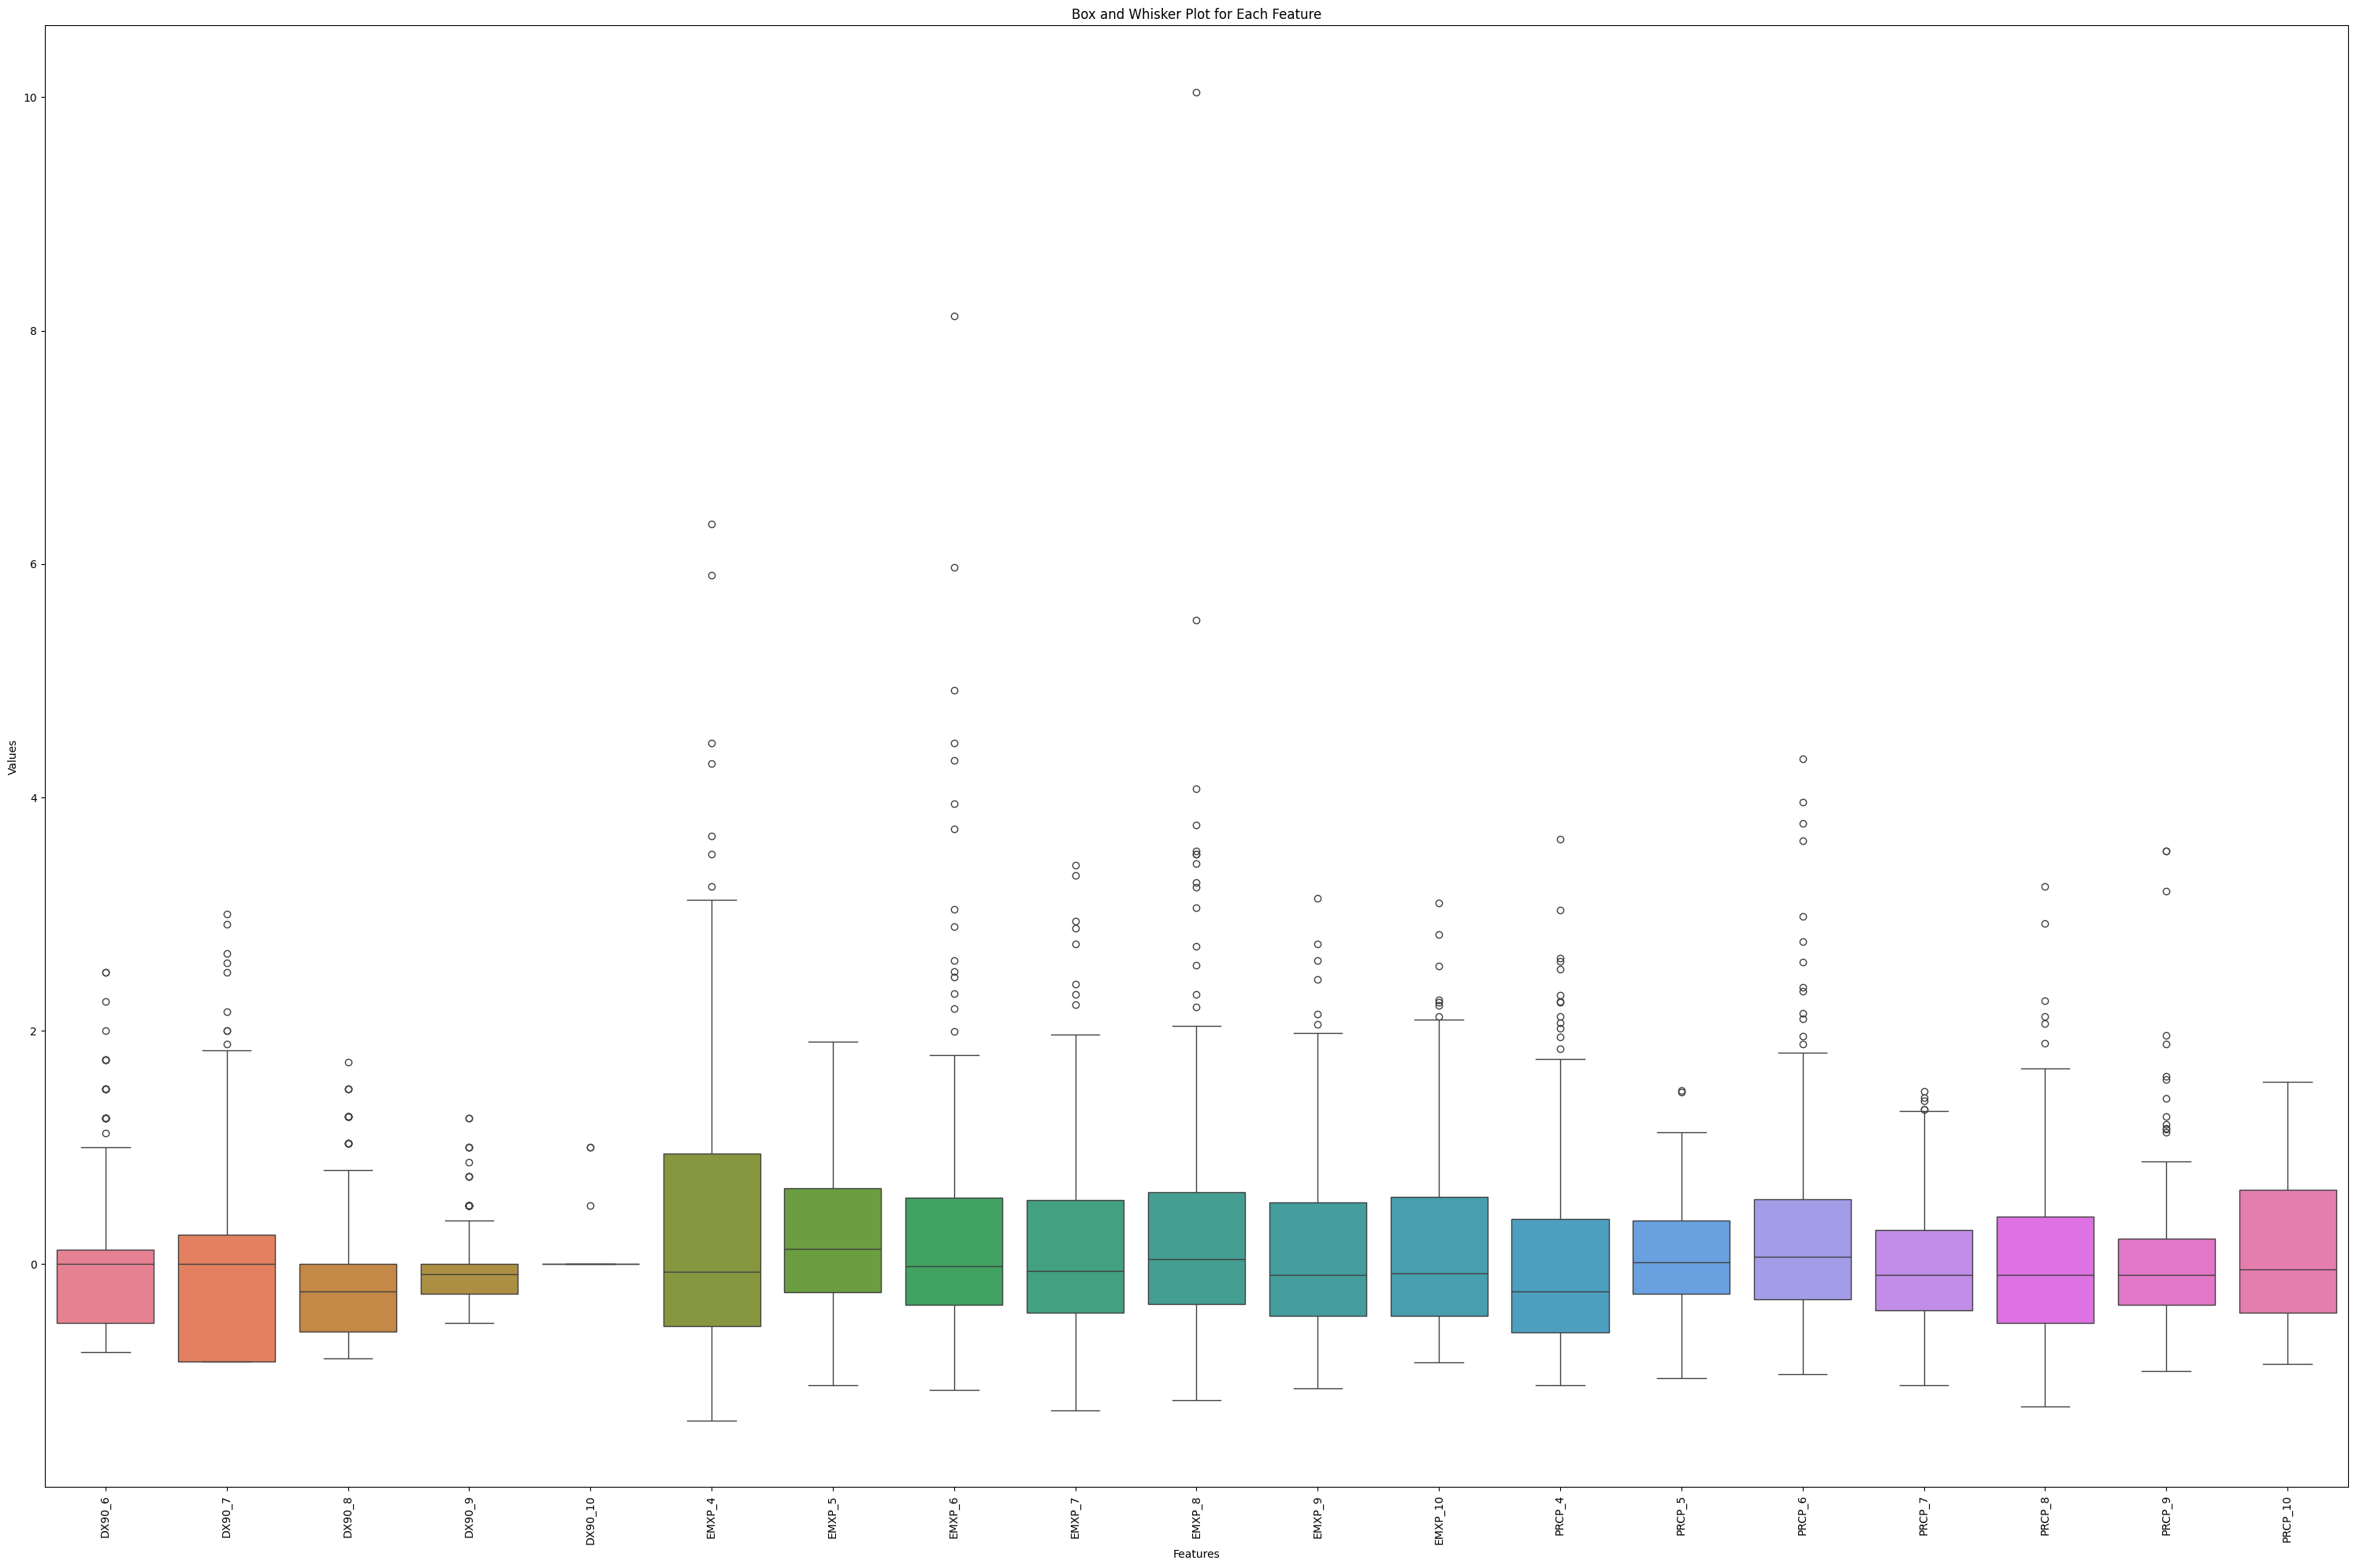

In [34]:
# Assuming df is your DataFrame containing your dataset
# Create a box and whisker plot for each feature
plt.figure(figsize=(30, 20))
sns.boxplot(data=X_hold_scaled_subset_3)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.xlabel('Features')
plt.ylabel('Values')
plt.title('Box and Whisker Plot for Each Feature')
plt.tight_layout()
plt.show()

In [35]:
X_train_scaled_subset_4 = X_train_scaled_subset_3.drop(columns=["DX90_10"],axis=1)
X_hold_scaled_subset_4 = X_hold_scaled_subset_3.drop(columns=["DX90_10"],axis=1)

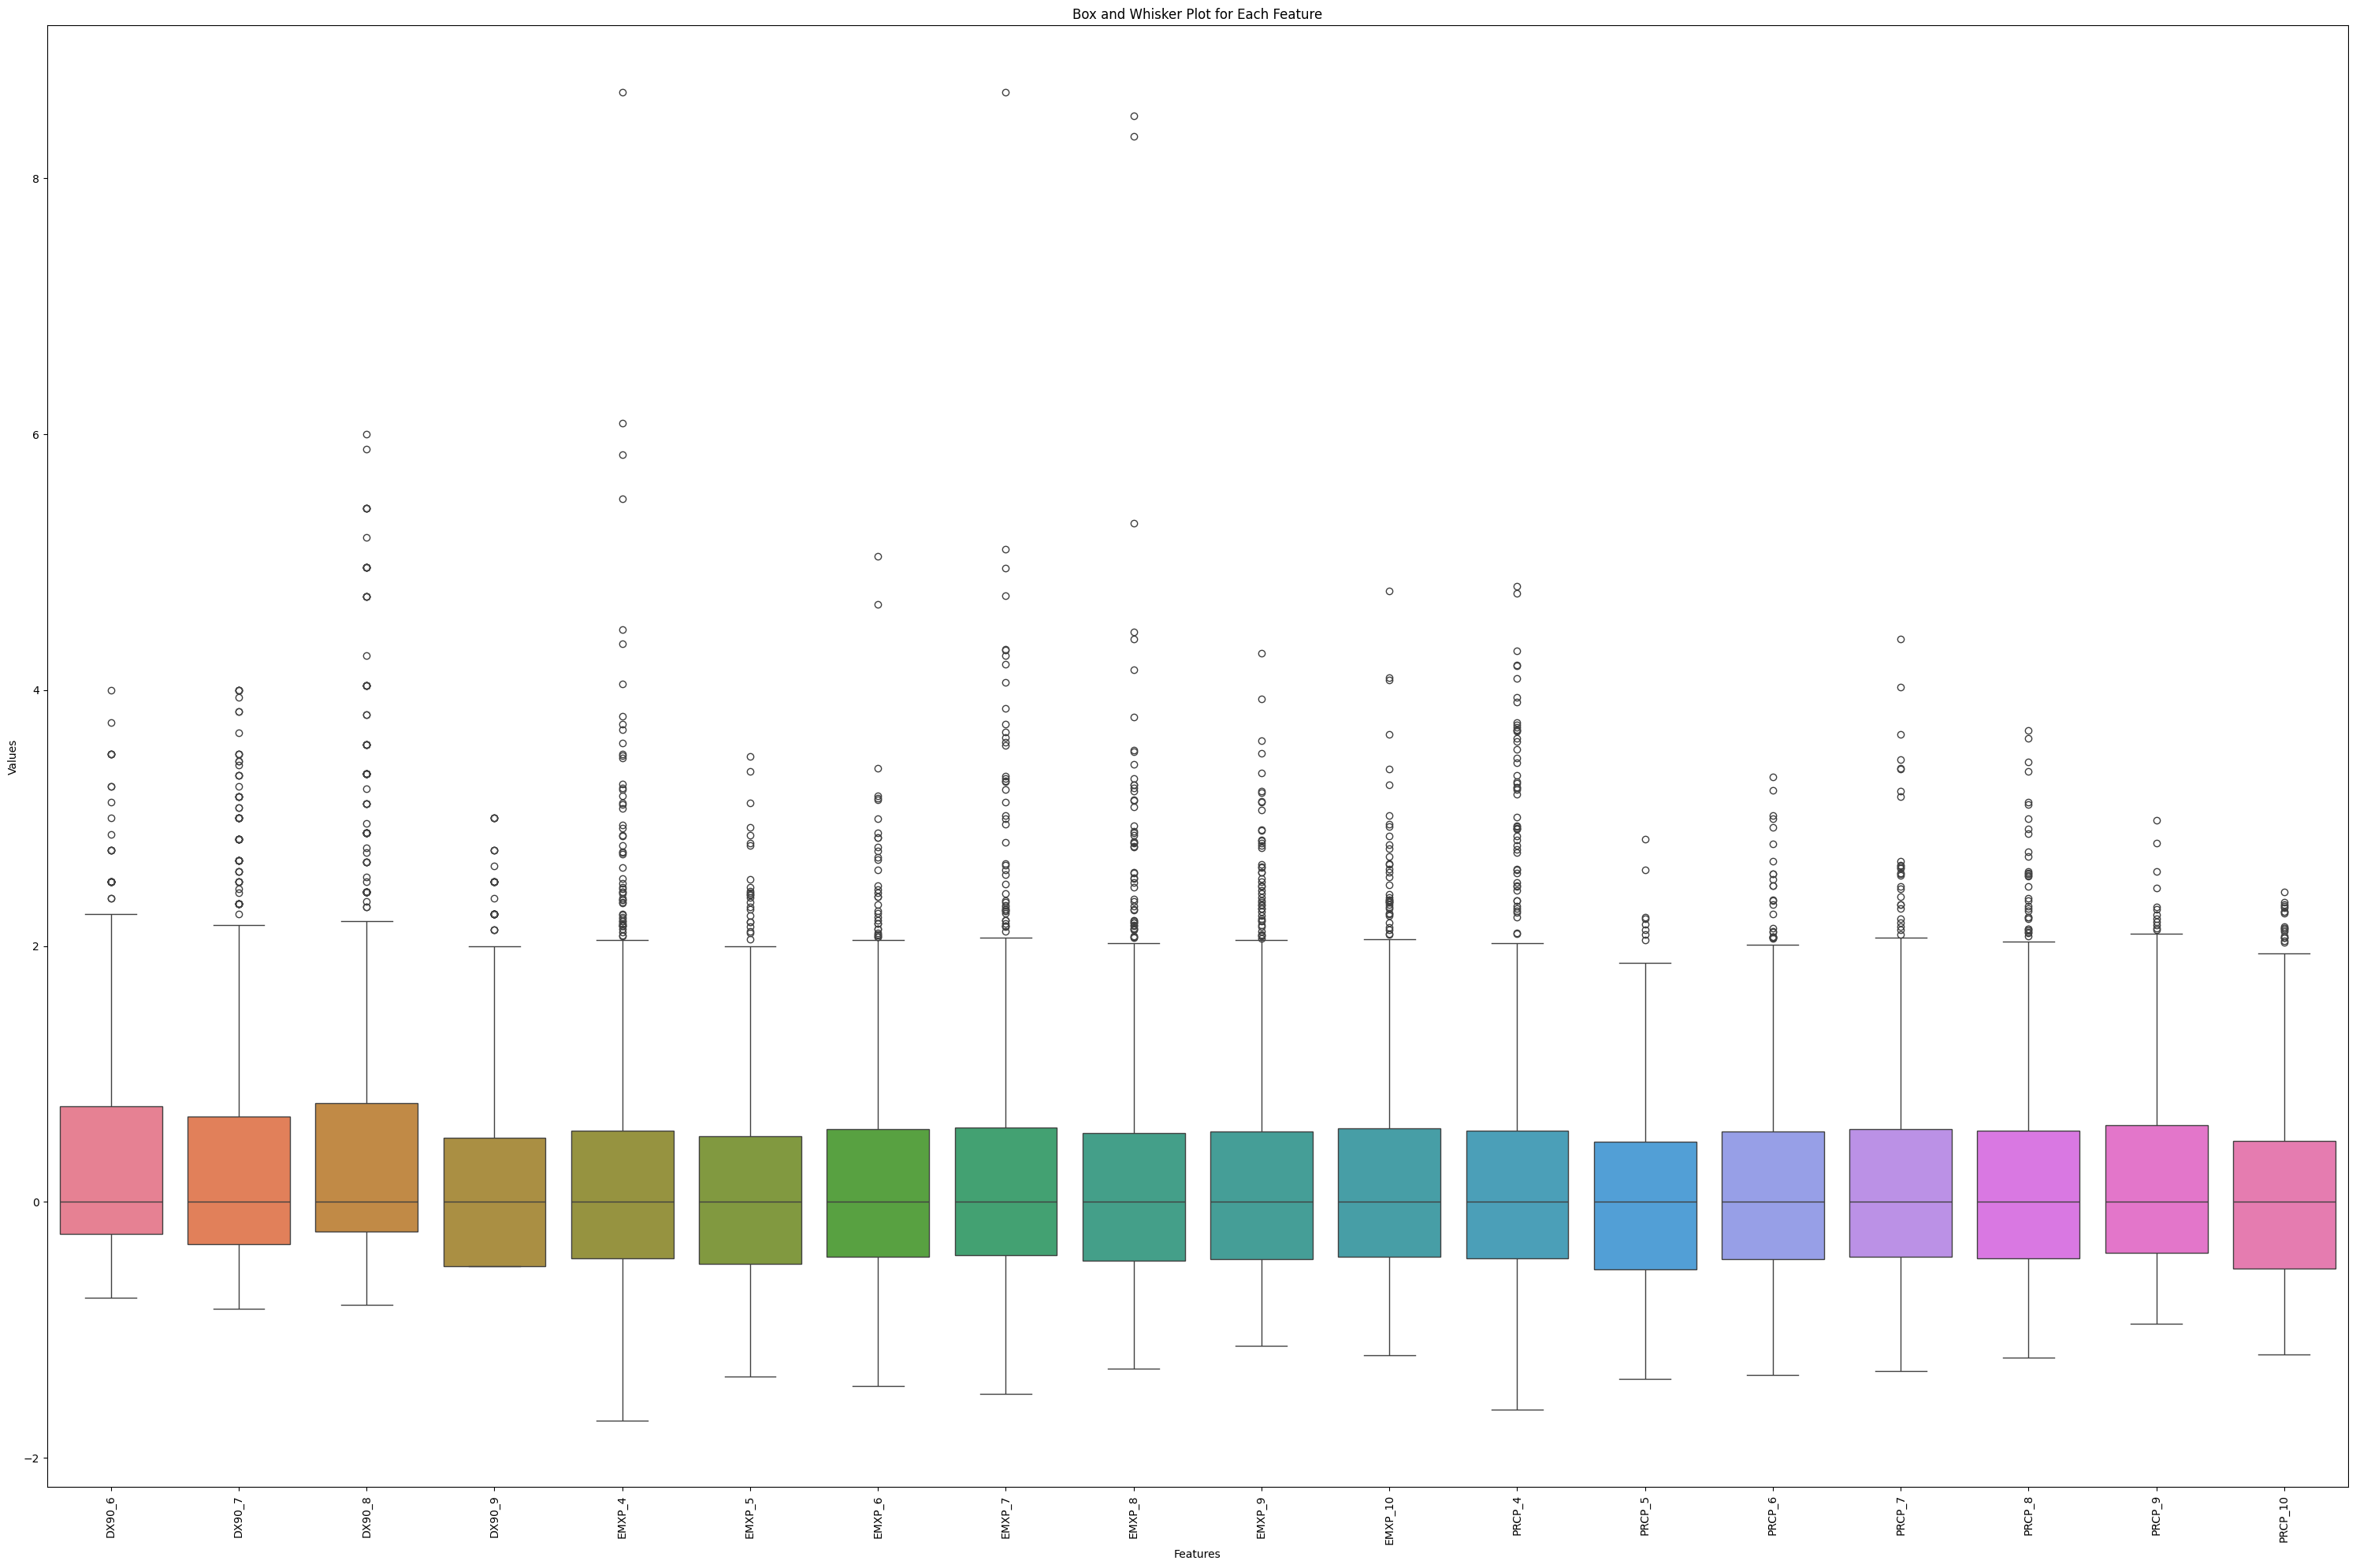

In [36]:
# Assuming df is your DataFrame containing your dataset
# Create a box and whisker plot for each feature
plt.figure(figsize=(30, 20))
sns.boxplot(data=X_train_scaled_subset_4)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.xlabel('Features')
plt.ylabel('Values')
plt.title('Box and Whisker Plot for Each Feature')
plt.tight_layout()
plt.show()

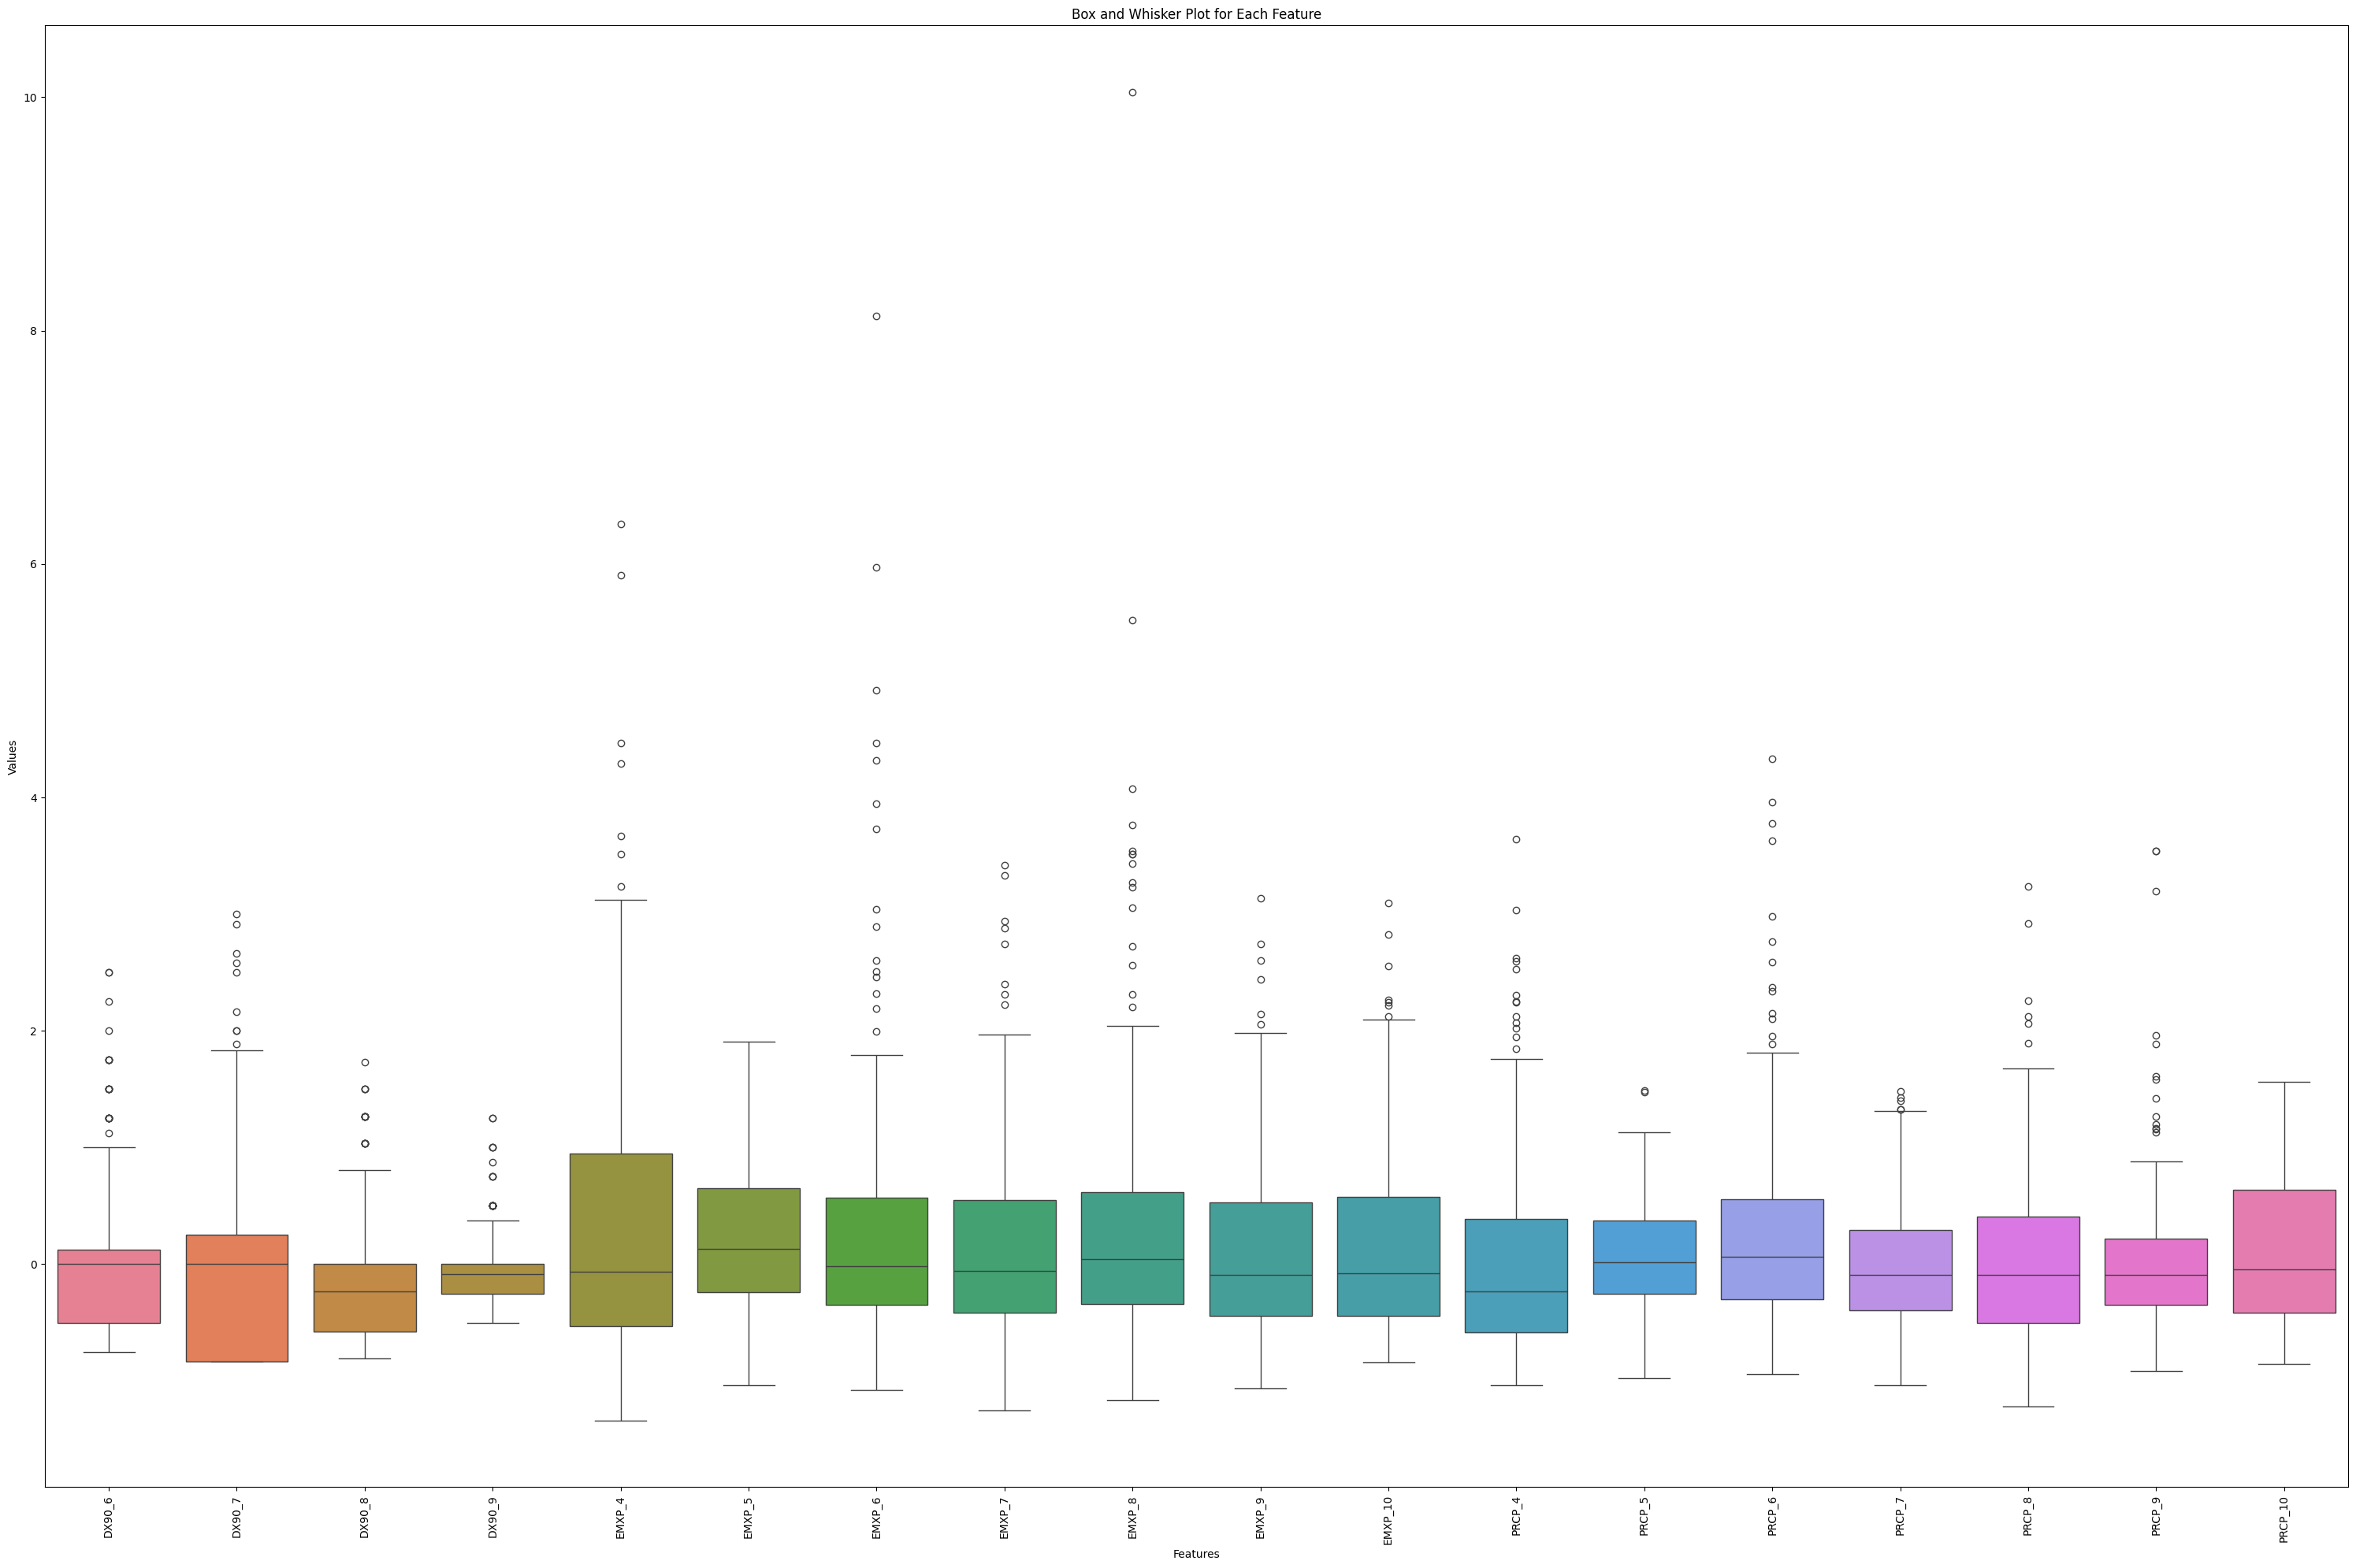

In [37]:
# Assuming df is your DataFrame containing your dataset
# Create a box and whisker plot for each feature
plt.figure(figsize=(30, 20))
sns.boxplot(data=X_hold_scaled_subset_4)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.xlabel('Features')
plt.ylabel('Values')
plt.title('Box and Whisker Plot for Each Feature')
plt.tight_layout()
plt.show()

Much Better

## Remove columns with extreme outliers

In [38]:
X_train_scaled_v2 = X_train_scaled.drop(columns=["EMSD_4", "SNOW_4", "DX90_10"], axis=1)
X_test_scaled_v2 = X_test_scaled.drop(columns=["EMSD_4", "SNOW_4", "DX90_10"], axis=1)
X_hold_scaled_v2 = X_hold_scaled.drop(columns=["EMSD_4", "SNOW_4", "DX90_10"], axis=1)


## Gradient Boosting

In [40]:
# Create a Gradient Boosting regressor
gb_regressor_v2 = GradientBoostingRegressor()

# Define a grid of hyperparameters to search
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of boosting stages
    'learning_rate': [0.01, 0.1, 0.5],  # Learning rate
    'max_depth': [3, 5, 7]  # Maximum depth of the individual regression estimators
}

In [41]:
# Perform grid search with 5-fold cross-validation
grid_search_gb_v2 = GridSearchCV(gb_regressor_v2, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_gb_v2.fit(X_train_scaled_v2, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.5],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error')

In [42]:
# Make predictions on the testing data using the best model
best_params_gb_v2 = grid_search_gb_v2.best_estimator_
gb_pred_v2 = best_params_gb_v2.predict(X_test_scaled_v2)

In [43]:
best_params_gb_v2

GradientBoostingRegressor(n_estimators=200)

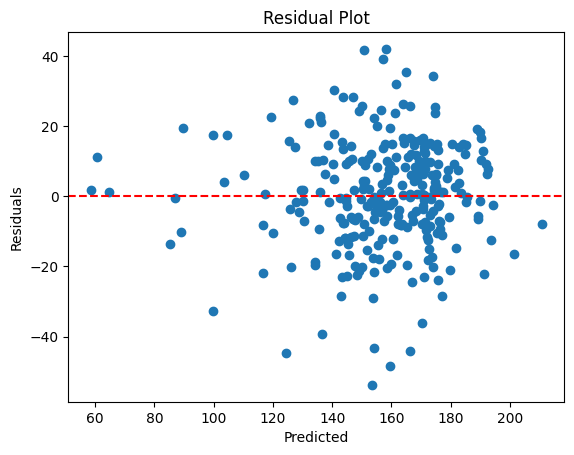

In [44]:
residuals_gb_v2 = y_test - gb_pred_v2
plt.scatter(gb_pred_v2, residuals_gb_v2)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')  # Horizontal line at y=0
plt.title('Residual Plot')
plt.show()

In [45]:
mse = mean_squared_error(y_test , gb_pred_v2)
r2 = r2_score(y_test, gb_pred_v2)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 236.62199193030477
R-squared: 0.6912054718772713


## Testing for GB (Unseen data)

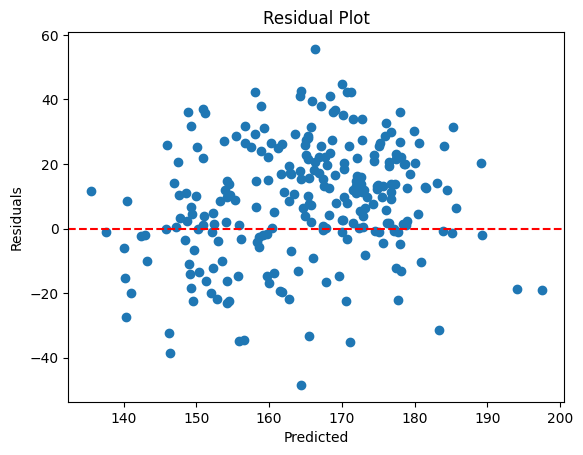

In [46]:
best_predictions_gb_hold_v2 = best_params_gb_v2.predict(X_hold_scaled_v2)

residuals_gb_hold_v2 = y_hold - best_predictions_gb_hold_v2
plt.scatter(best_predictions_gb_hold_v2, residuals_gb_hold_v2)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')  # Horizontal line at y=0
plt.title('Residual Plot')
plt.show()

In [47]:
mse = mean_squared_error(y_hold , best_predictions_gb_hold_v2 )
r2 = r2_score(y_hold, best_predictions_gb_hold_v2)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 402.9862197196652
R-squared: 0.255336184249391


## Random Forest

In [48]:
# Define the parameter grid
param_grid = {
        'n_estimators': [50, 100, 150],  # Reducing the number of trees
    'max_depth': [None, 10, 20],      # Limiting the maximum depth of trees
    'min_samples_split': [5, 10, 15]  # Increasing the min_samples_split
}

# Create the Random Forest regressor
rf_regressor_v2 = RandomForestRegressor(random_state=42)

# Create the GridSearchCV object
grid_search_rf_v2 = GridSearchCV(estimator=rf_regressor_v2, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)


# Perform the grid search
grid_search_rf_v2.fit(X_train_scaled_v2, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_split': [5, 10, 15],
                         'n_estimators': [50, 100, 150]},
             scoring='neg_mean_squared_error')

In [49]:
# Make predictions on the testing data using the best model
best_params_rf_v2 = grid_search_rf_v2.best_estimator_
print(best_params_rf_v2)
rf_pred_v2 = best_params_rf_v2.predict(X_test_scaled_v2)

RandomForestRegressor(min_samples_split=5, random_state=42)


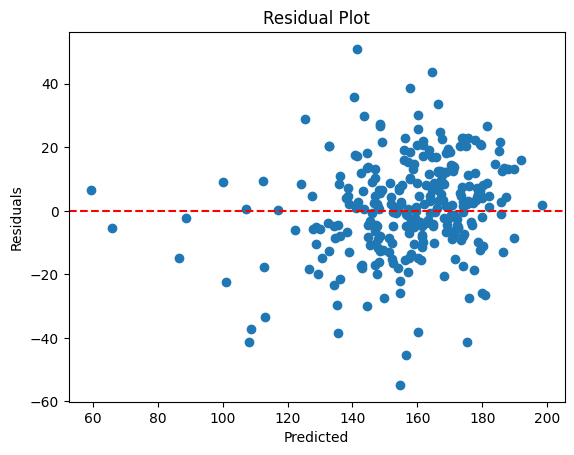

In [50]:
residuals_rf_v2 = y_test - rf_pred_v2
plt.scatter(rf_pred_v2, residuals_rf_v2)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')  # Horizontal line at y=0
plt.title('Residual Plot')
plt.show()

In [51]:
mse = mean_squared_error(y_test , rf_pred_v2)
r2 = r2_score(y_test, rf_pred_v2)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 234.5732670641462
R-squared: 0.6938790823187095


## Testing on Random Forest Model (Unseen data)

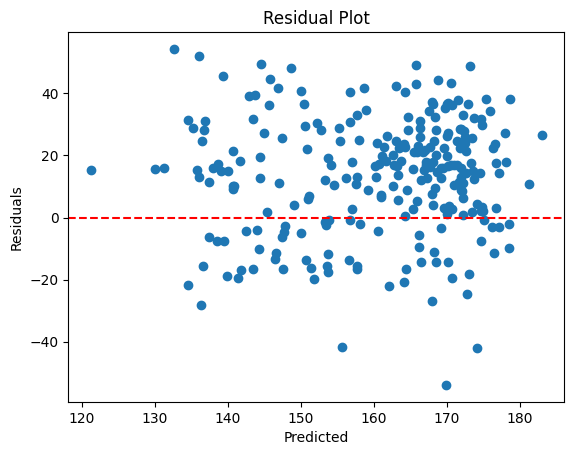

In [52]:
best_predictions_rf_hold_v2 = best_params_rf_v2.predict(X_hold_scaled_v2)

residuals_rf_hold_v2 = y_hold - best_predictions_rf_hold_v2
plt.scatter(best_predictions_rf_hold_v2, residuals_rf_hold_v2)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')  # Horizontal line at y=0
plt.title('Residual Plot')
plt.show()

In [53]:
mse = mean_squared_error(y_hold , best_predictions_rf_hold_v2 )
r2 = r2_score(y_hold, best_predictions_rf_hold_v2)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 531.6092460664944
R-squared: 0.01765829625746318


## Extra Tree

In [59]:
from sklearn.ensemble import ExtraTreesRegressor

In [60]:
# Define the Extra Trees regressor
extra_trees = ExtraTreesRegressor(random_state=42)

# Define the parameter grid for Grid Search
param_grid = {
    'n_estimators': [50, 100, 150, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],       # Maximum depth of the trees
    'min_samples_split': [2, 5, 10]        # Minimum number of samples required to split a node
}

# Create the Grid Search CV object
grid_search_et = GridSearchCV(estimator=extra_trees, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Perform the Grid Search
grid_search_et.fit(X_train_scaled_v2, y_train)

GridSearchCV(cv=5, estimator=ExtraTreesRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 150, 200]},
             scoring='neg_mean_squared_error')

In [61]:
# Get the best hyperparameters and model
best_params_et_v2 = grid_search_et .best_params_
print("Best Hyperparameters:", best_params_et_v2)
best_model_et_v2 = grid_search_et .best_estimator_

et_pred_v2 = best_model_et_v2.predict(X_test_scaled_v2)

Best Hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


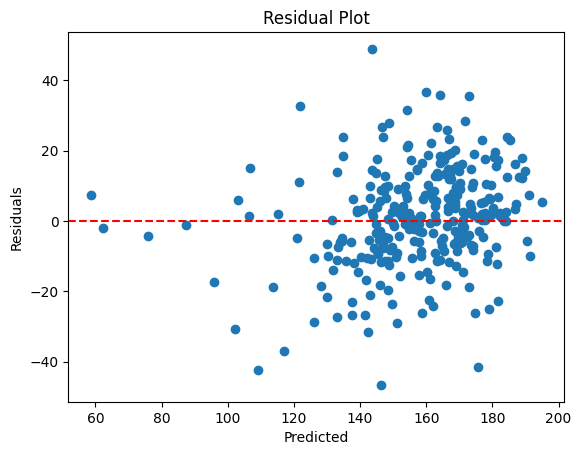

In [62]:
residuals_et_v2 = y_test - et_pred_v2
plt.scatter(et_pred_v2, residuals_et_v2)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')  # Horizontal line at y=0
plt.title('Residual Plot')
plt.show()

In [63]:
mse = mean_squared_error(y_test , et_pred_v2)
r2 = r2_score(y_test, et_pred_v2)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 204.3915916666666
R-squared: 0.7332665295136566


## Testing on ET (Unseen Data)

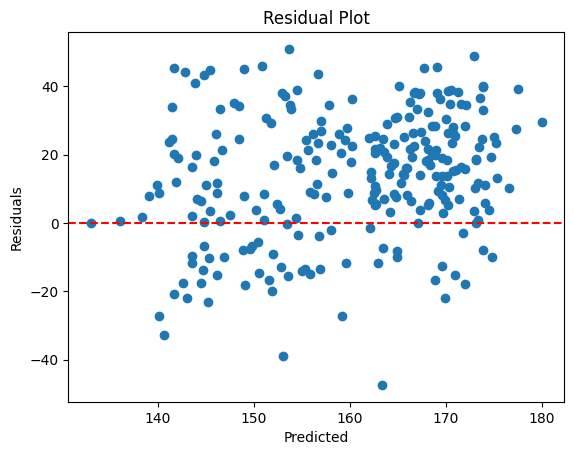

In [64]:
best_predictions_et_hold_v2 = best_model_et_v2.predict(X_hold_scaled_v2)

residuals_xgb_hold_v2 = y_hold - best_predictions_et_hold_v2
plt.scatter(best_predictions_et_hold_v2, residuals_xgb_hold_v2)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')  # Horizontal line at y=0
plt.title('Residual Plot')
plt.show()

In [65]:
mse = mean_squared_error(y_hold , best_predictions_et_hold_v2)
r2 = r2_score(y_hold, best_predictions_et_hold_v2)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 523.8698394960471
R-squared: 0.031959668727230994


## Adaboost

In [66]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

In [67]:
# Define the base estimator (Decision Tree) for AdaBoost
base_estimator = DecisionTreeRegressor(random_state=42)

# Define the AdaBoost regressor
adaboost = AdaBoostRegressor(base_estimator=base_estimator, random_state=42)

# Define the parameter grid for Grid Search
param_grid = {
    'n_estimators': [50, 100, 150, 200],      # Number of boosting stages
    'learning_rate': [0.01, 0.1, 0.5, 1.0],   # Learning rate shrinks the contribution of each regressor
}

In [68]:
# Create the Grid Search CV object
grid_search_ada = GridSearchCV(estimator=adaboost, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Perform the Grid Search
grid_search_ada.fit(X_train_scaled_v2, y_train)

c:\Users\hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(random_state=42),
                                         random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.5, 1.0],
                         'n_estimators': [50, 100, 150, 200]},
             scoring='neg_mean_squared_error')

In [69]:
# Get the best parameters and best AdaBoost model
best_params = grid_search_ada.best_params_
print(best_params)
best_adaboost_model = grid_search_ada.best_estimator_

ada_pred_v2 = best_adaboost_model.predict(X_test_scaled_v2)

{'learning_rate': 1.0, 'n_estimators': 200}


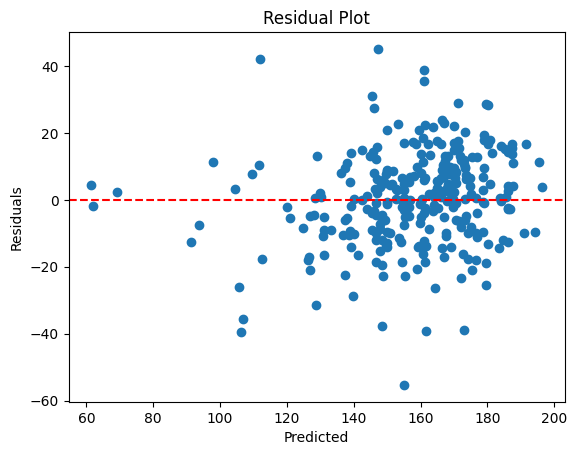

In [70]:
residuals_ada_v2 = y_test - ada_pred_v2
plt.scatter(ada_pred_v2, residuals_ada_v2)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')  # Horizontal line at y=0
plt.title('Residual Plot')
plt.show()

In [71]:
mse = mean_squared_error(y_test , ada_pred_v2)
r2 = r2_score(y_test, ada_pred_v2)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 199.9687368421053
R-squared: 0.7390384079319061


## Validation for Adaboost (Unseen Data)

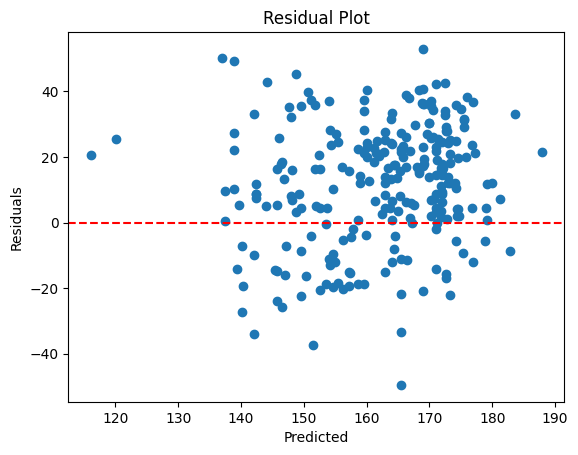

In [72]:
best_predictions_ada_hold_v2 = best_adaboost_model.predict(X_hold_scaled_v2)

residuals_ada_hold_v2 = y_hold - best_predictions_ada_hold_v2
plt.scatter(best_predictions_ada_hold_v2, residuals_ada_hold_v2)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')  # Horizontal line at y=0
plt.title('Residual Plot')
plt.show()

In [73]:
mse = mean_squared_error(y_hold , best_predictions_ada_hold_v2)
r2 = r2_score(y_hold, best_predictions_ada_hold_v2)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 477.61604743083006
R-squared: 0.11743039602947036


## Bagging Regressor

In [75]:
from sklearn.ensemble import BaggingRegressor

In [76]:
# Define the base estimator (Decision Tree) for Bagging
base_estimator = DecisionTreeRegressor(random_state=42)

# Define the Bagging regressor
bagging_regressor = BaggingRegressor(base_estimator=base_estimator, random_state=42)

# Define the parameter grid for Grid Search
param_grid = {
    'n_estimators': [50, 100, 150, 200],      # Number of base estimators (trees)
    'max_samples': [0.5, 0.7, 0.9],            # Number of samples to draw from X to train each base estimator
    'max_features': [0.5, 0.7, 0.9],           # Number of features to draw from X to train each base estimator
}



In [77]:
# Create the Grid Search CV object
grid_search_bag = GridSearchCV(estimator=bagging_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Perform the Grid Search
grid_search_bag.fit(X_train_scaled_v2, y_train)

c:\Users\hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=BaggingRegressor(base_estimator=DecisionTreeRegressor(random_state=42),
                                        random_state=42),
             n_jobs=-1,
             param_grid={'max_features': [0.5, 0.7, 0.9],
                         'max_samples': [0.5, 0.7, 0.9],
                         'n_estimators': [50, 100, 150, 200]},
             scoring='neg_mean_squared_error')

In [78]:
# Get the best hyperparameters and model
best_params_bag_v2 = grid_search_bag.best_params_
print("Best Hyperparameters:", best_params_bag_v2)

best_model_bag_v2 = grid_search_bag.best_estimator_

bag_pred_v2 = best_model_bag_v2.predict(X_test_scaled_v2)

Best Hyperparameters: {'max_features': 0.5, 'max_samples': 0.9, 'n_estimators': 100}


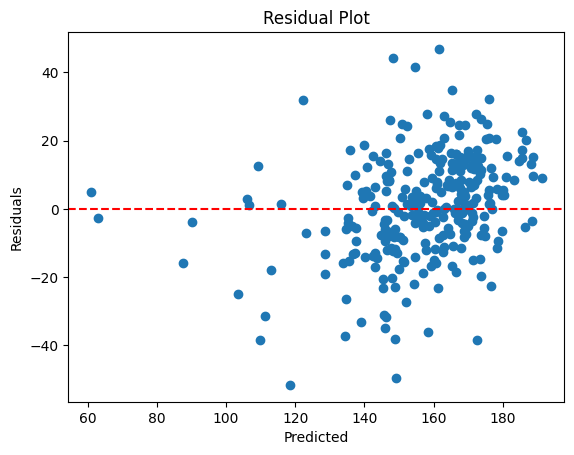

In [79]:
residuals_bag_v2 = y_test - bag_pred_v2
plt.scatter(bag_pred_v2, residuals_bag_v2)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')  # Horizontal line at y=0
plt.title('Residual Plot')
plt.show()

In [80]:
mse = mean_squared_error(y_test , bag_pred_v2)
r2 = r2_score(y_test, bag_pred_v2)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 233.96851793355253
R-squared: 0.6946682871634955


## Testing for Bagging (Unseen data)

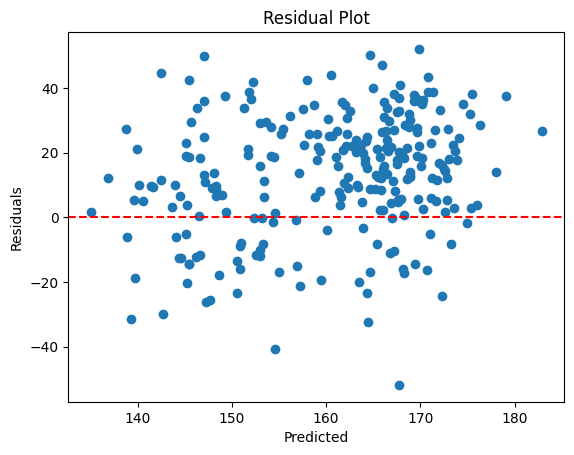

In [81]:
best_predictions_bag_hold_v2 = best_model_bag_v2.predict(X_hold_scaled_v2)

residuals_bag_hold_v2 = y_hold - best_predictions_bag_hold_v2
plt.scatter(best_predictions_bag_hold_v2, residuals_bag_hold_v2)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')  # Horizontal line at y=0
plt.title('Residual Plot')
plt.show()

In [82]:
mse = mean_squared_error(y_hold , best_predictions_bag_hold_v2)
r2 = r2_score(y_hold, best_predictions_bag_hold_v2)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 520.7557249483959
R-squared: 0.03771412957046183


## Stacking

In [58]:
from sklearn.model_selection import cross_val_predict

In [83]:
predictions_GB_v2 = cross_val_predict(grid_search_gb_v2, X_train_scaled_v2, y_train, cv=5)

In [84]:
predictions_rf_v2 = cross_val_predict(grid_search_rf_v2, X_train_scaled_v2, y_train, cv=5)

In [85]:
predictions_et_v2 = cross_val_predict(grid_search_et, X_train_scaled_v2, y_train, cv=5)

In [86]:
predictions_ada_v2 = cross_val_predict(grid_search_ada, X_train_scaled_v2, y_train, cv=5)

c:\Users\hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_est

In [87]:
predictions_bag_v2 = cross_val_predict(grid_search_bag, X_train_scaled_v2, y_train, cv=5)

c:\Users\hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\hp\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_est

In [88]:
stacked_train_predictions = [predictions_GB_v2, predictions_rf_v2, predictions_et_v2, predictions_ada_v2, predictions_bag_v2]
stacked_val_predictions = [gb_pred_v2, rf_pred_v2, et_pred_v2, ada_pred_v2, bag_pred_v2]
stacked_test_predictions = [best_predictions_gb_hold_v2, best_predictions_rf_hold_v2, best_predictions_et_hold_v2, best_predictions_ada_hold_v2, best_predictions_bag_hold_v2]

In [104]:
X_stacked_train = np.column_stack(stacked_train_predictions)
X_stacked_test = np.column_stack(stacked_val_predictions)
X_stacked_hold = np.column_stack(stacked_test_predictions )

'''
y_train
y_test
y_hold
'''

'\ny_train\ny_test\ny_hold\n'

In [90]:
X_stacked_train_pd = pd.DataFrame(data=X_stacked_train, columns=['pred_gb', 'pred_rf', 'pred_et', 'pred_ada', 'pred_bag'])

In [91]:
X_stacked_train_pd

,pred_gb,pred_rf,pred_et,pred_ada,pred_bag
0,145.791923,152.105739,147.111292,148.3,148.382000
1,160.626699,168.293571,166.145948,161.2,162.438000
2,193.962536,182.769001,182.507300,183.0,185.053333
3,153.032579,157.898920,151.015932,152.6,156.772000
4,142.537074,141.160952,144.775853,146.1,144.149333
...,...,...,...,...,...
1134,142.576023,150.520677,150.035777,149.6,148.320333
1135,161.127927,171.237421,173.992953,168.3,166.159333
1136,149.923279,138.182214,150.552866,142.1,149.571333
1137,183.732358,186.044422,184.499009,181.9,181.813333


In [105]:
# Define the XGBoost regressor
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', random_state=42)

# Define the hyperparameters grid for grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

In [106]:
# Perform grid search with cross-validation
grid_search_xgb = GridSearchCV(estimator=xg_reg, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_xgb.fit(X_stacked_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error')

In [107]:
# Get the best hyperparameters and model
best_params_xgb = grid_search_xgb.best_params_
print("Best Hyperparameters:", best_params_xgb)
best_model_xgb = grid_search_xgb.best_estimator_

xgb_pred = best_model_xgb.predict(X_stacked_test)

Best Hyperparameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}


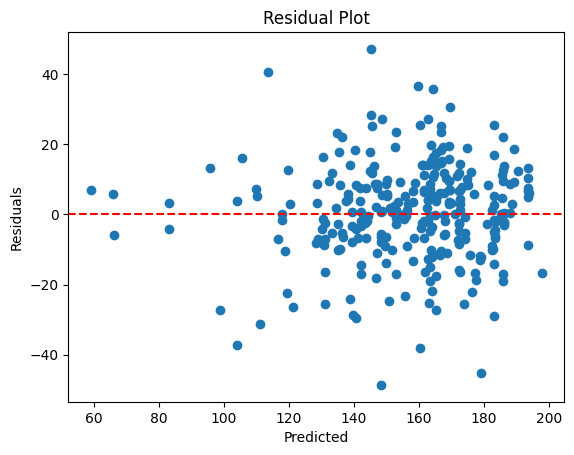

In [108]:
residuals_xgb = y_test - xgb_pred
plt.scatter(xgb_pred, residuals_xgb)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')  # Horizontal line at y=0
plt.title('Residual Plot')
plt.show()

In [109]:
mse = mean_squared_error(y_test , xgb_pred)
r2 = r2_score(y_test, xgb_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 194.69893411508443
R-squared: 0.745915563487547


## Testing on Stacked Model (Unseen data)

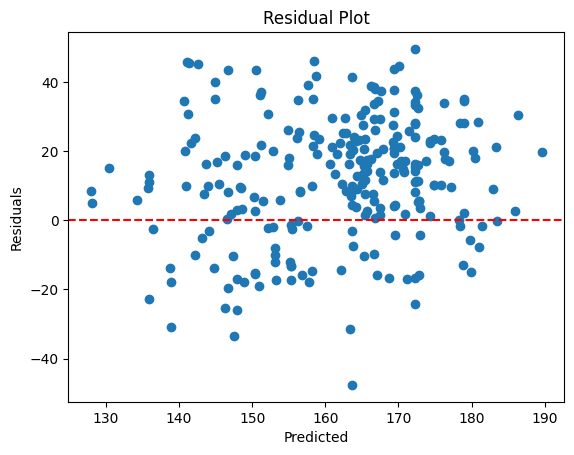

In [110]:
best_predictions_xgb_hold = best_model_xgb.predict(X_stacked_hold)

residuals_xgb_hold = y_hold - best_predictions_xgb_hold
plt.scatter(best_predictions_xgb_hold, residuals_xgb_hold)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')  # Horizontal line at y=0
plt.title('Residual Plot')
plt.show()

In [111]:
mse = mean_squared_error(y_hold , best_predictions_xgb_hold)
r2 = r2_score(y_hold, best_predictions_xgb_hold)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 465.22261052840065
R-squared: 0.14033178461900464


## Train + Validation fit

In [100]:
# Define the XGBoost regressor
xg_reg_v2 = xgb.XGBRegressor(objective ='reg:squarederror', random_state=42)

# Define the hyperparameters grid for grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

In [121]:
X_stacked_train.shape

(1139, 5)

In [120]:
X_stacked_test.shape

(285, 5)

In [122]:
y_train.shape

(1139,)

In [123]:
y_test.shape

(285,)

In [124]:
X_stacked_train_v2 = np.concatenate([X_stacked_train, X_stacked_test], axis=0)
y_train_v2 = np.concatenate([y_train, y_test], axis=0)

In [125]:
X_stacked_train_v2.shape

(1424, 5)

In [126]:
y_train_v2.shape

(1424,)

In [127]:
# Perform grid search with cross-validation
grid_search_xgb_v2 = GridSearchCV(estimator=xg_reg_v2, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_xgb_v2.fit(X_stacked_train_v2, y_train_v2)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error')

In [128]:
# Get the best hyperparameters and model
best_params_xgb_v2 = grid_search_xgb_v2.best_params_
print("Best Hyperparameters:", best_params_xgb)
best_model_xgb_v2 = grid_search_xgb_v2.best_estimator_

xgb_pred_hold = best_model_xgb_v2.predict(X_stacked_hold)

Best Hyperparameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}


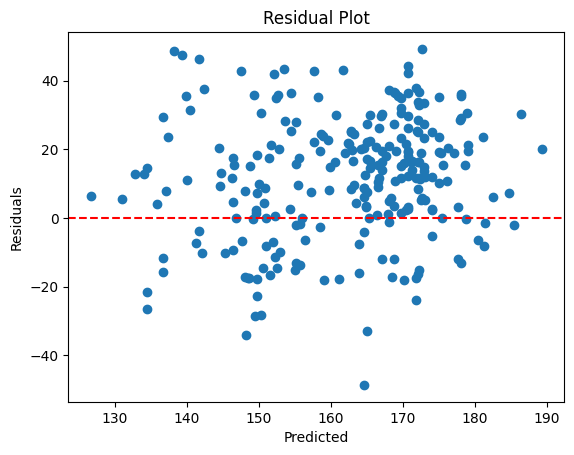

In [129]:
residuals_xgb_hold = y_hold- xgb_pred_hold
plt.scatter(xgb_pred_hold, residuals_xgb_hold)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')  # Horizontal line at y=0
plt.title('Residual Plot')
plt.show()

In [130]:
mse = mean_squared_error(y_hold , xgb_pred_hold)
r2 = r2_score(y_hold, xgb_pred_hold)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 455.7145034806948
R-squared: 0.15790147541298571
